In [1]:
import pandas as pd

data = pd.read_csv('data/^NDX_raw_data.csv')
data.rename(columns={'Date': 'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume'}, inplace=True)

data = data.iloc[:3524]
data = data.iloc[:100]

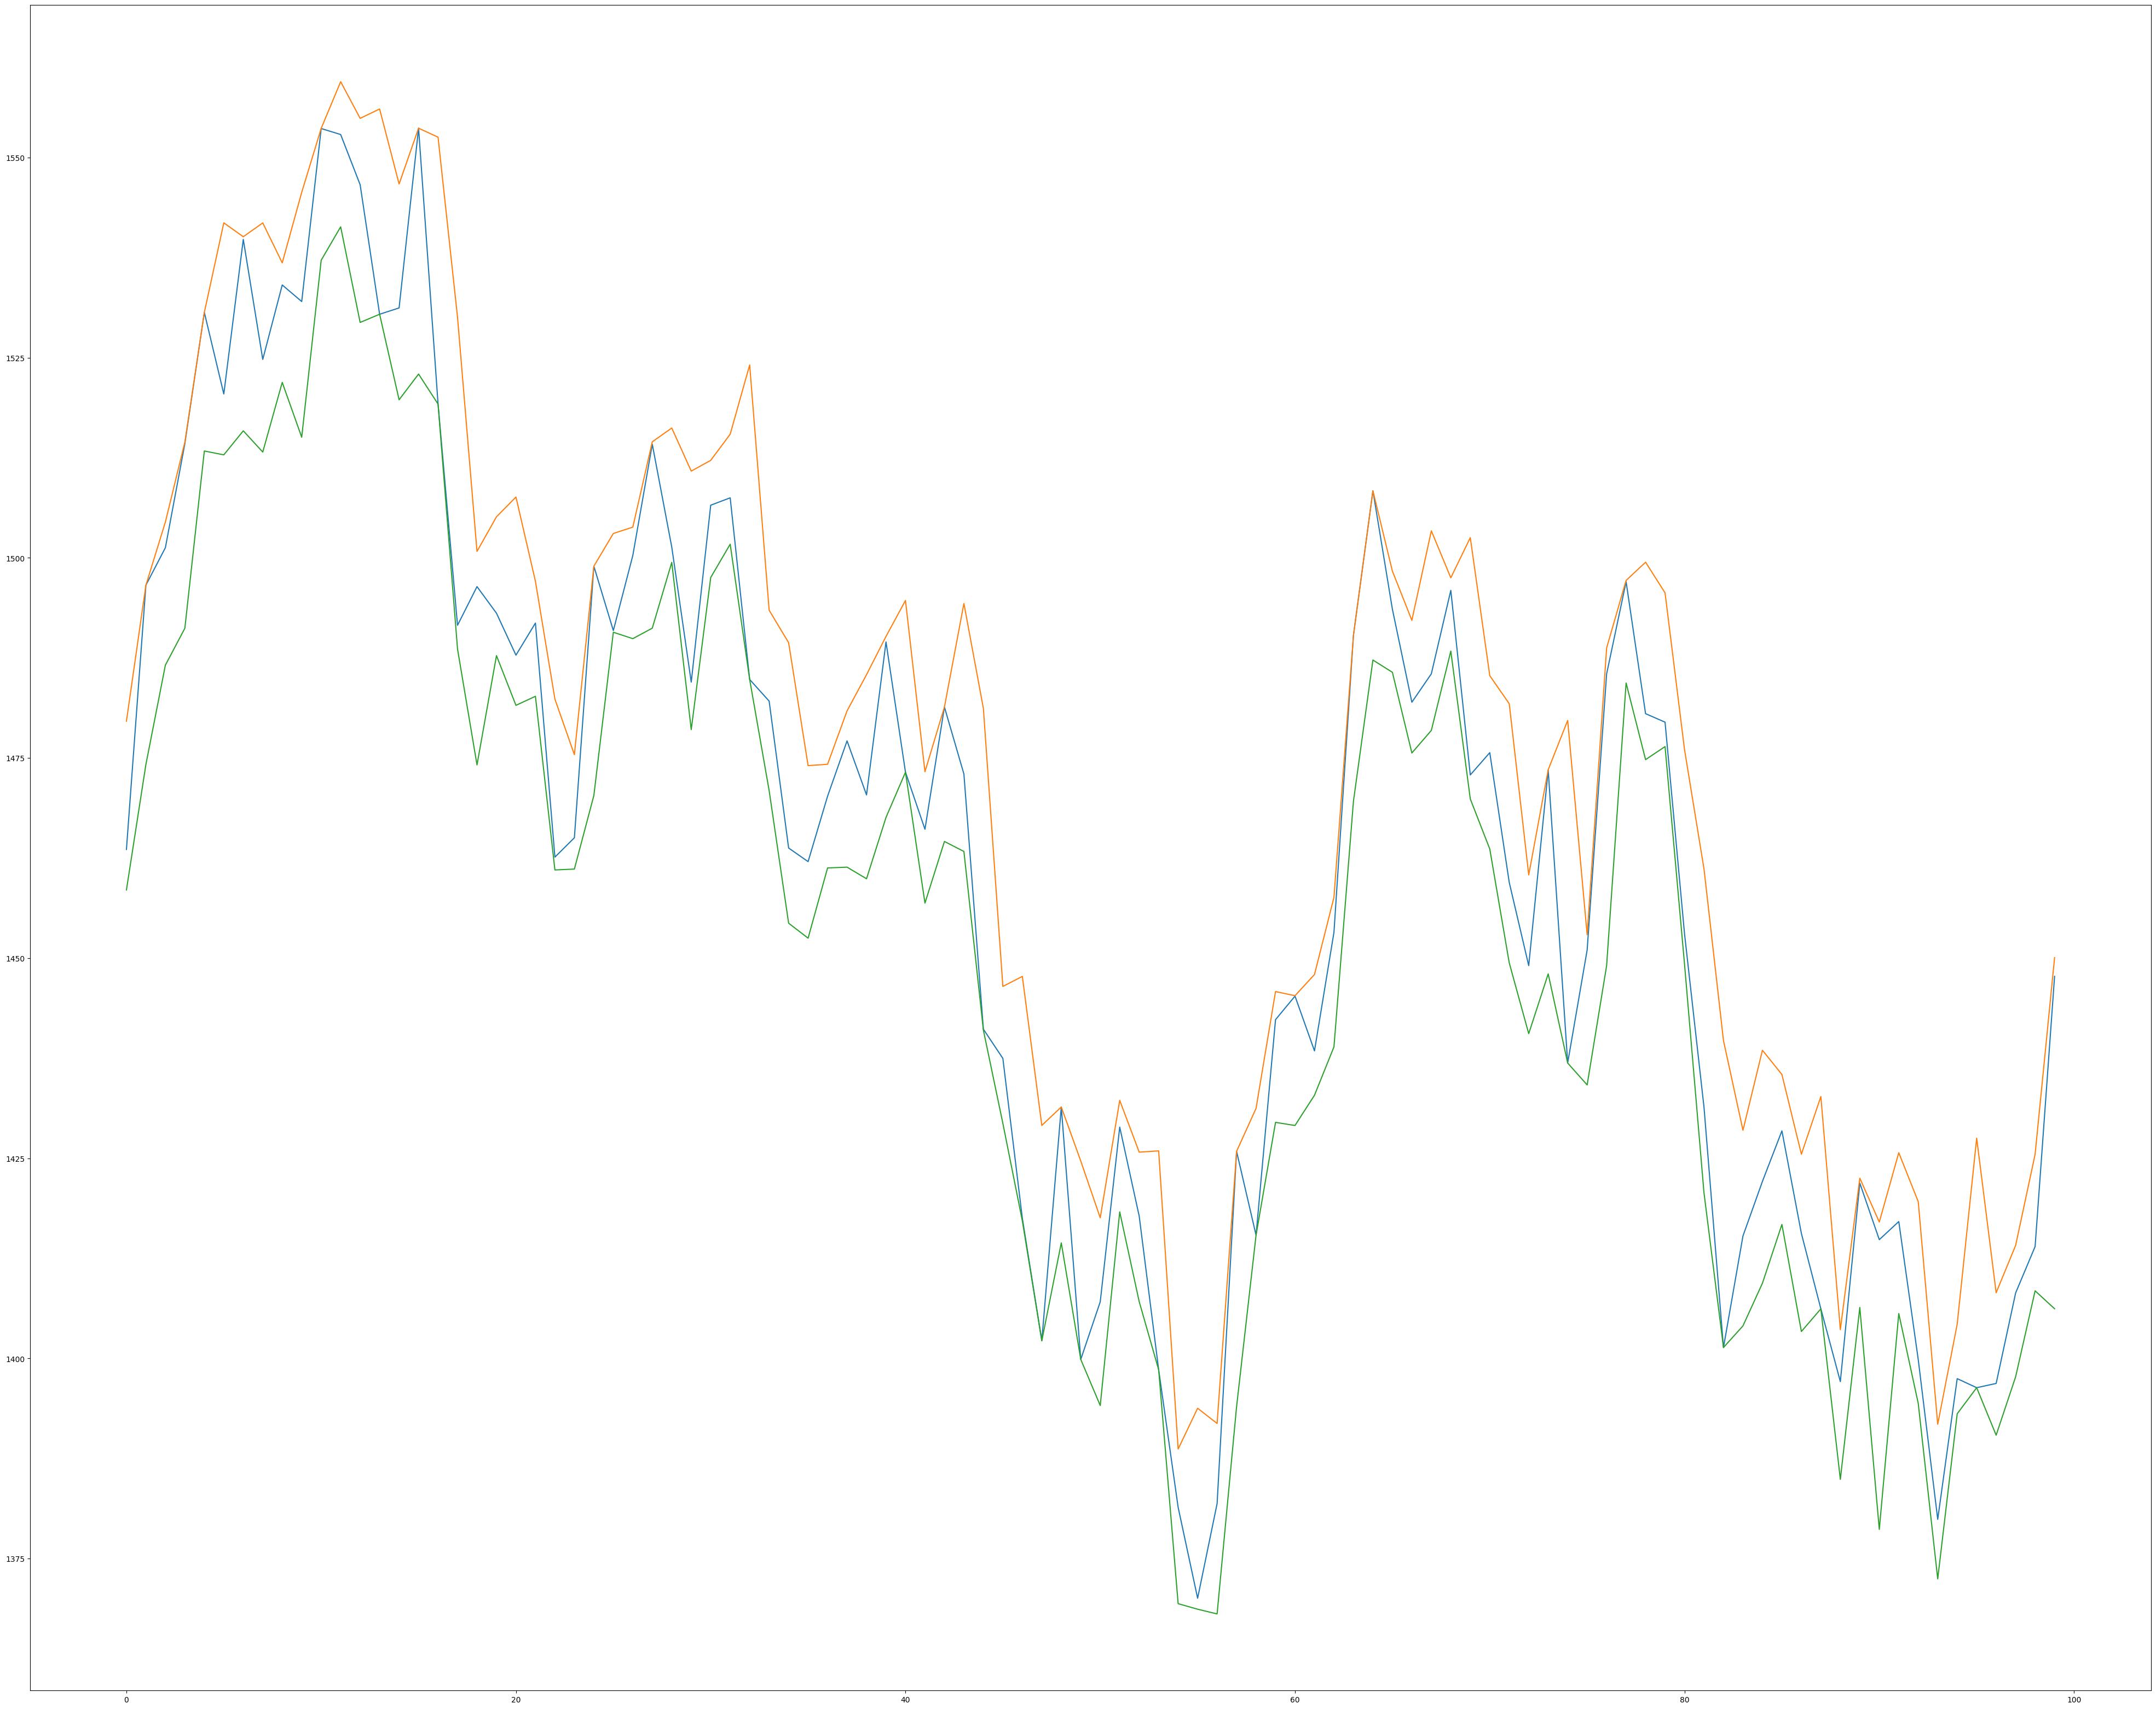

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))
plt.plot(data.index[:100], data['close'].iloc[:100], label='close')
plt.plot(data.index[:100], data['high'].iloc[:100], label='high')
plt.plot(data.index[:100], data['low'].iloc[:100], label='low')

In [3]:
from scipy.signal import savgol_filter

# Apply Savitzky-Golay filter
window_length = 11  # Window length (must be odd)
polyorder = 2      # Polynomial order

data['s_close'] = savgol_filter(data['close'], window_length, polyorder)
data['s_high'] = savgol_filter(data['high'], window_length, polyorder)
data['s_low'] = savgol_filter(data['low'], window_length, polyorder)

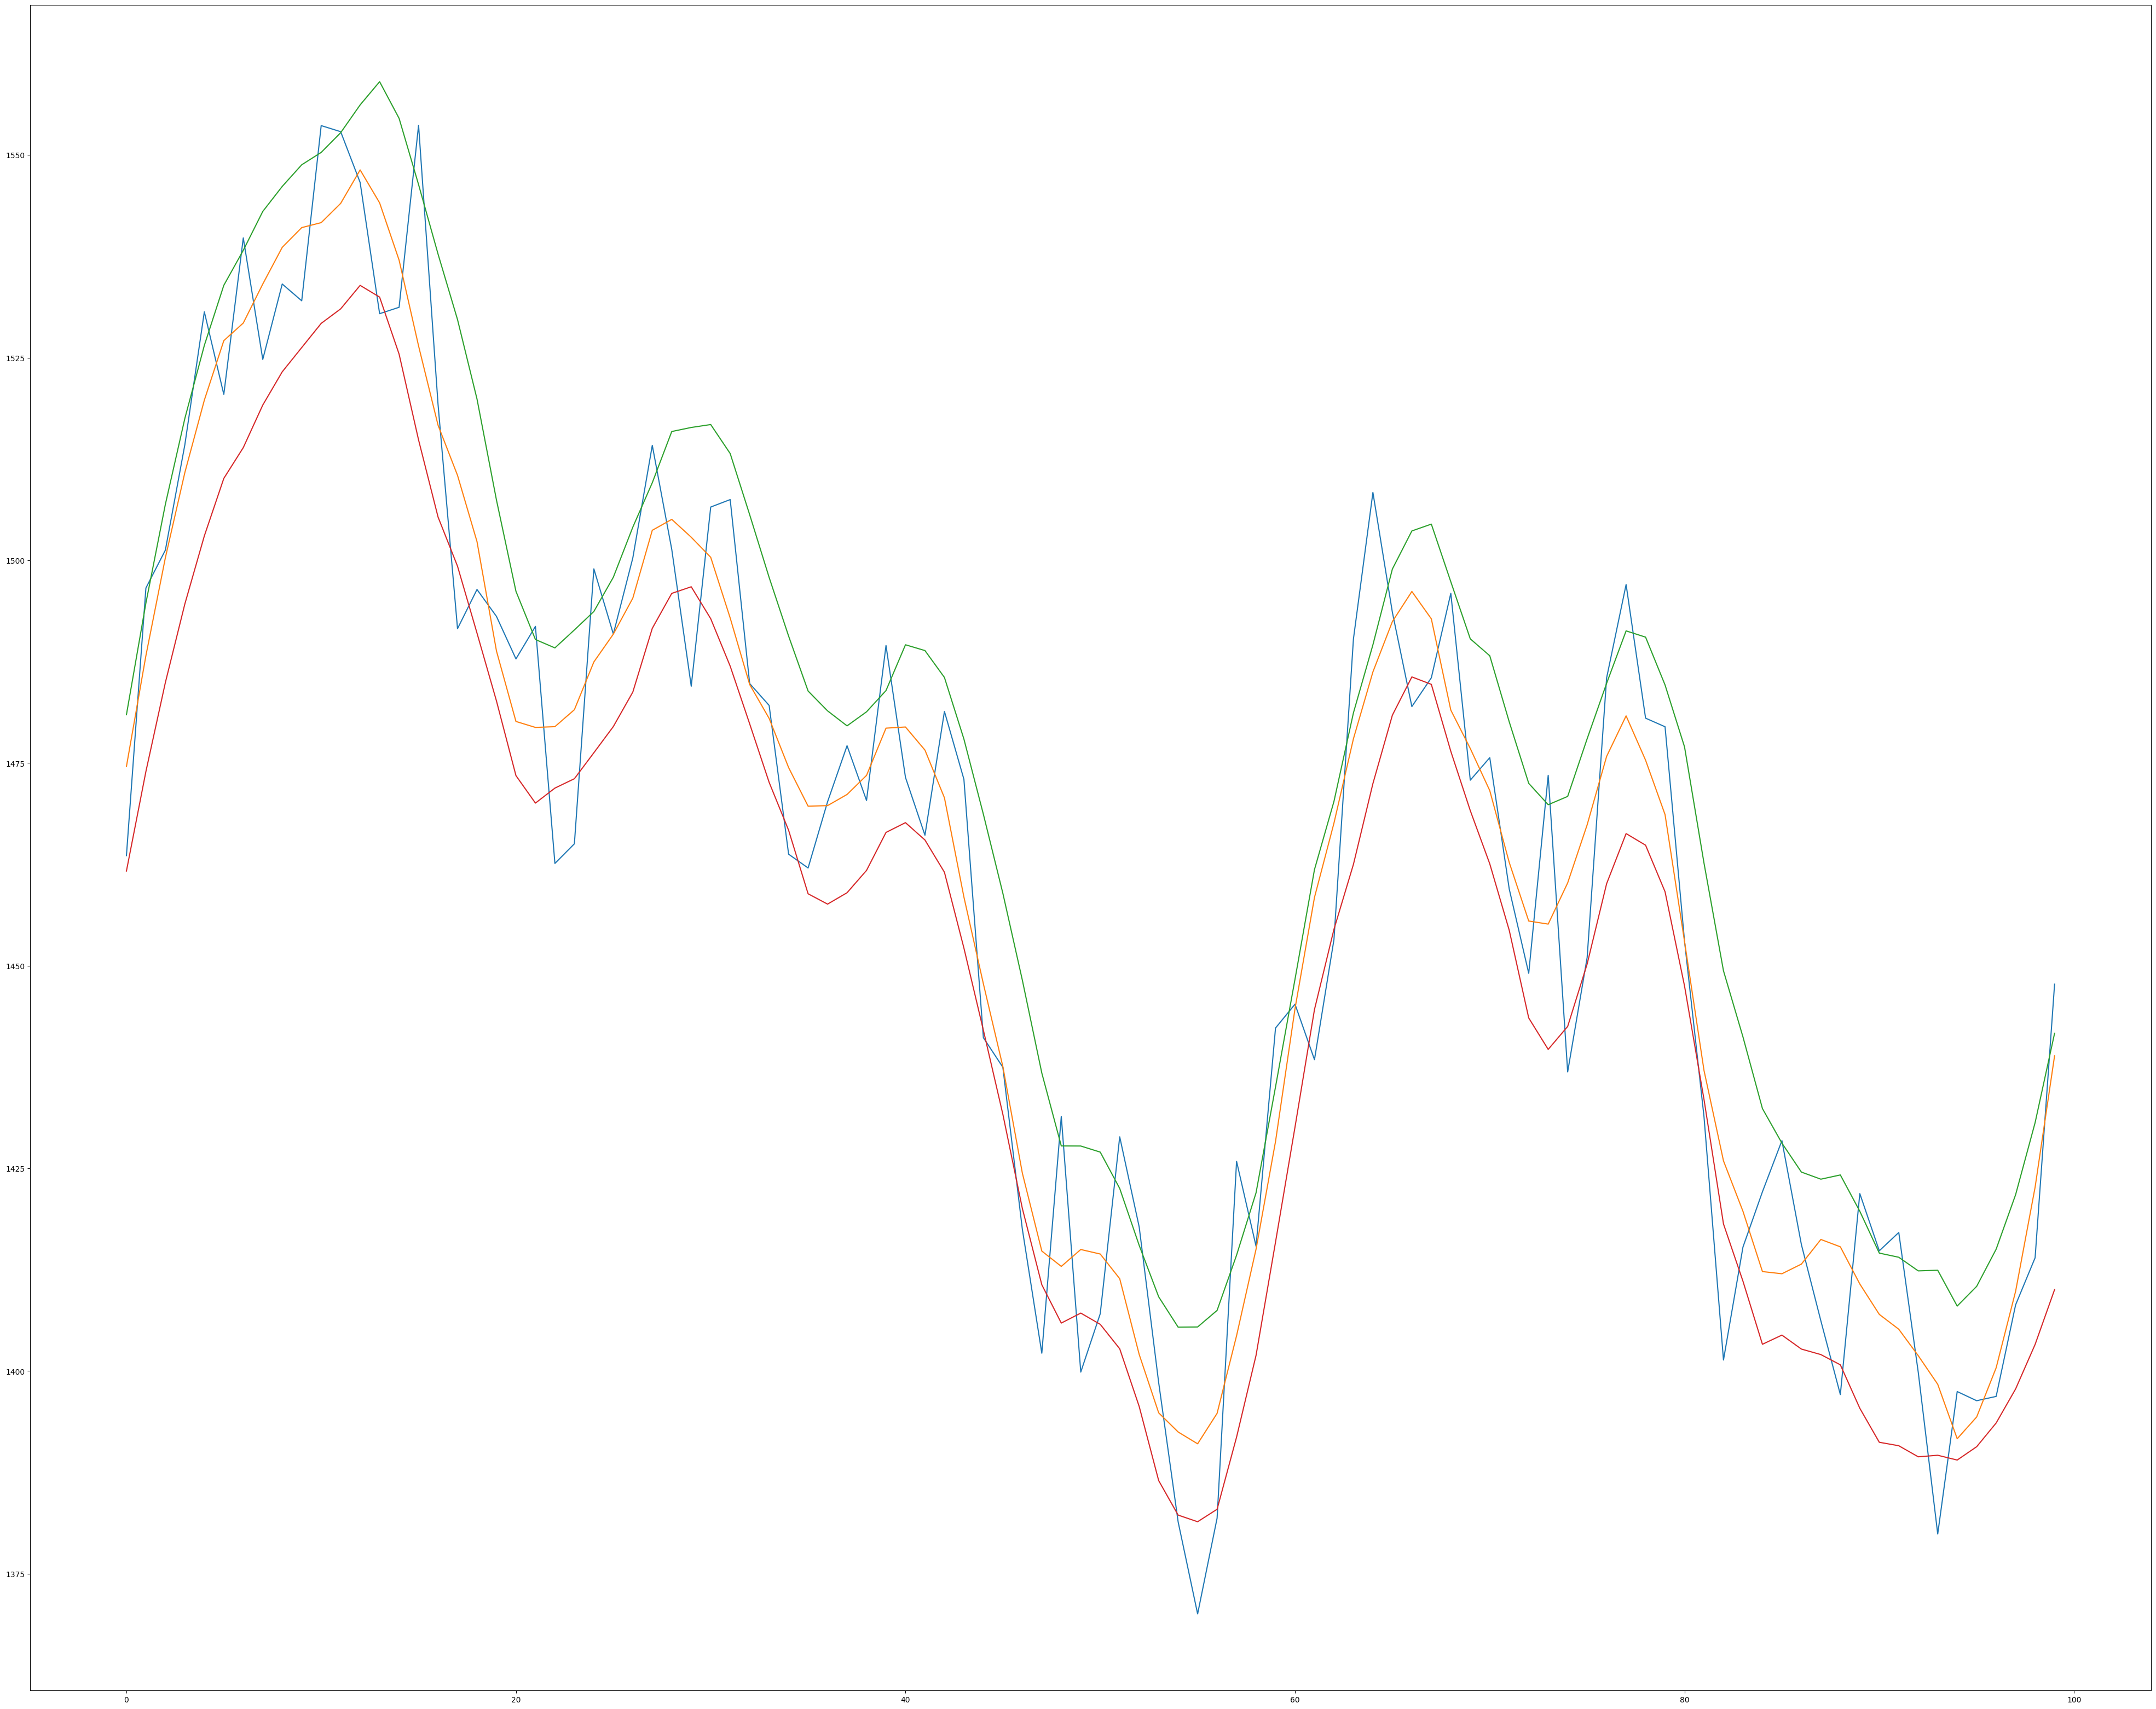

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))
plt.plot(data.index, data['close'], label='close')
plt.plot(data.index, data['s_close'], label='s_close')
plt.plot(data.index, data['s_high'], label='s_high')
plt.plot(data.index, data['s_low'], label='s_low')

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(data['close'], model='additive', period=14)
trend = decomposition.trend
season = decomposition.seasonal
residual = decomposition.resid

detrend = season + residual

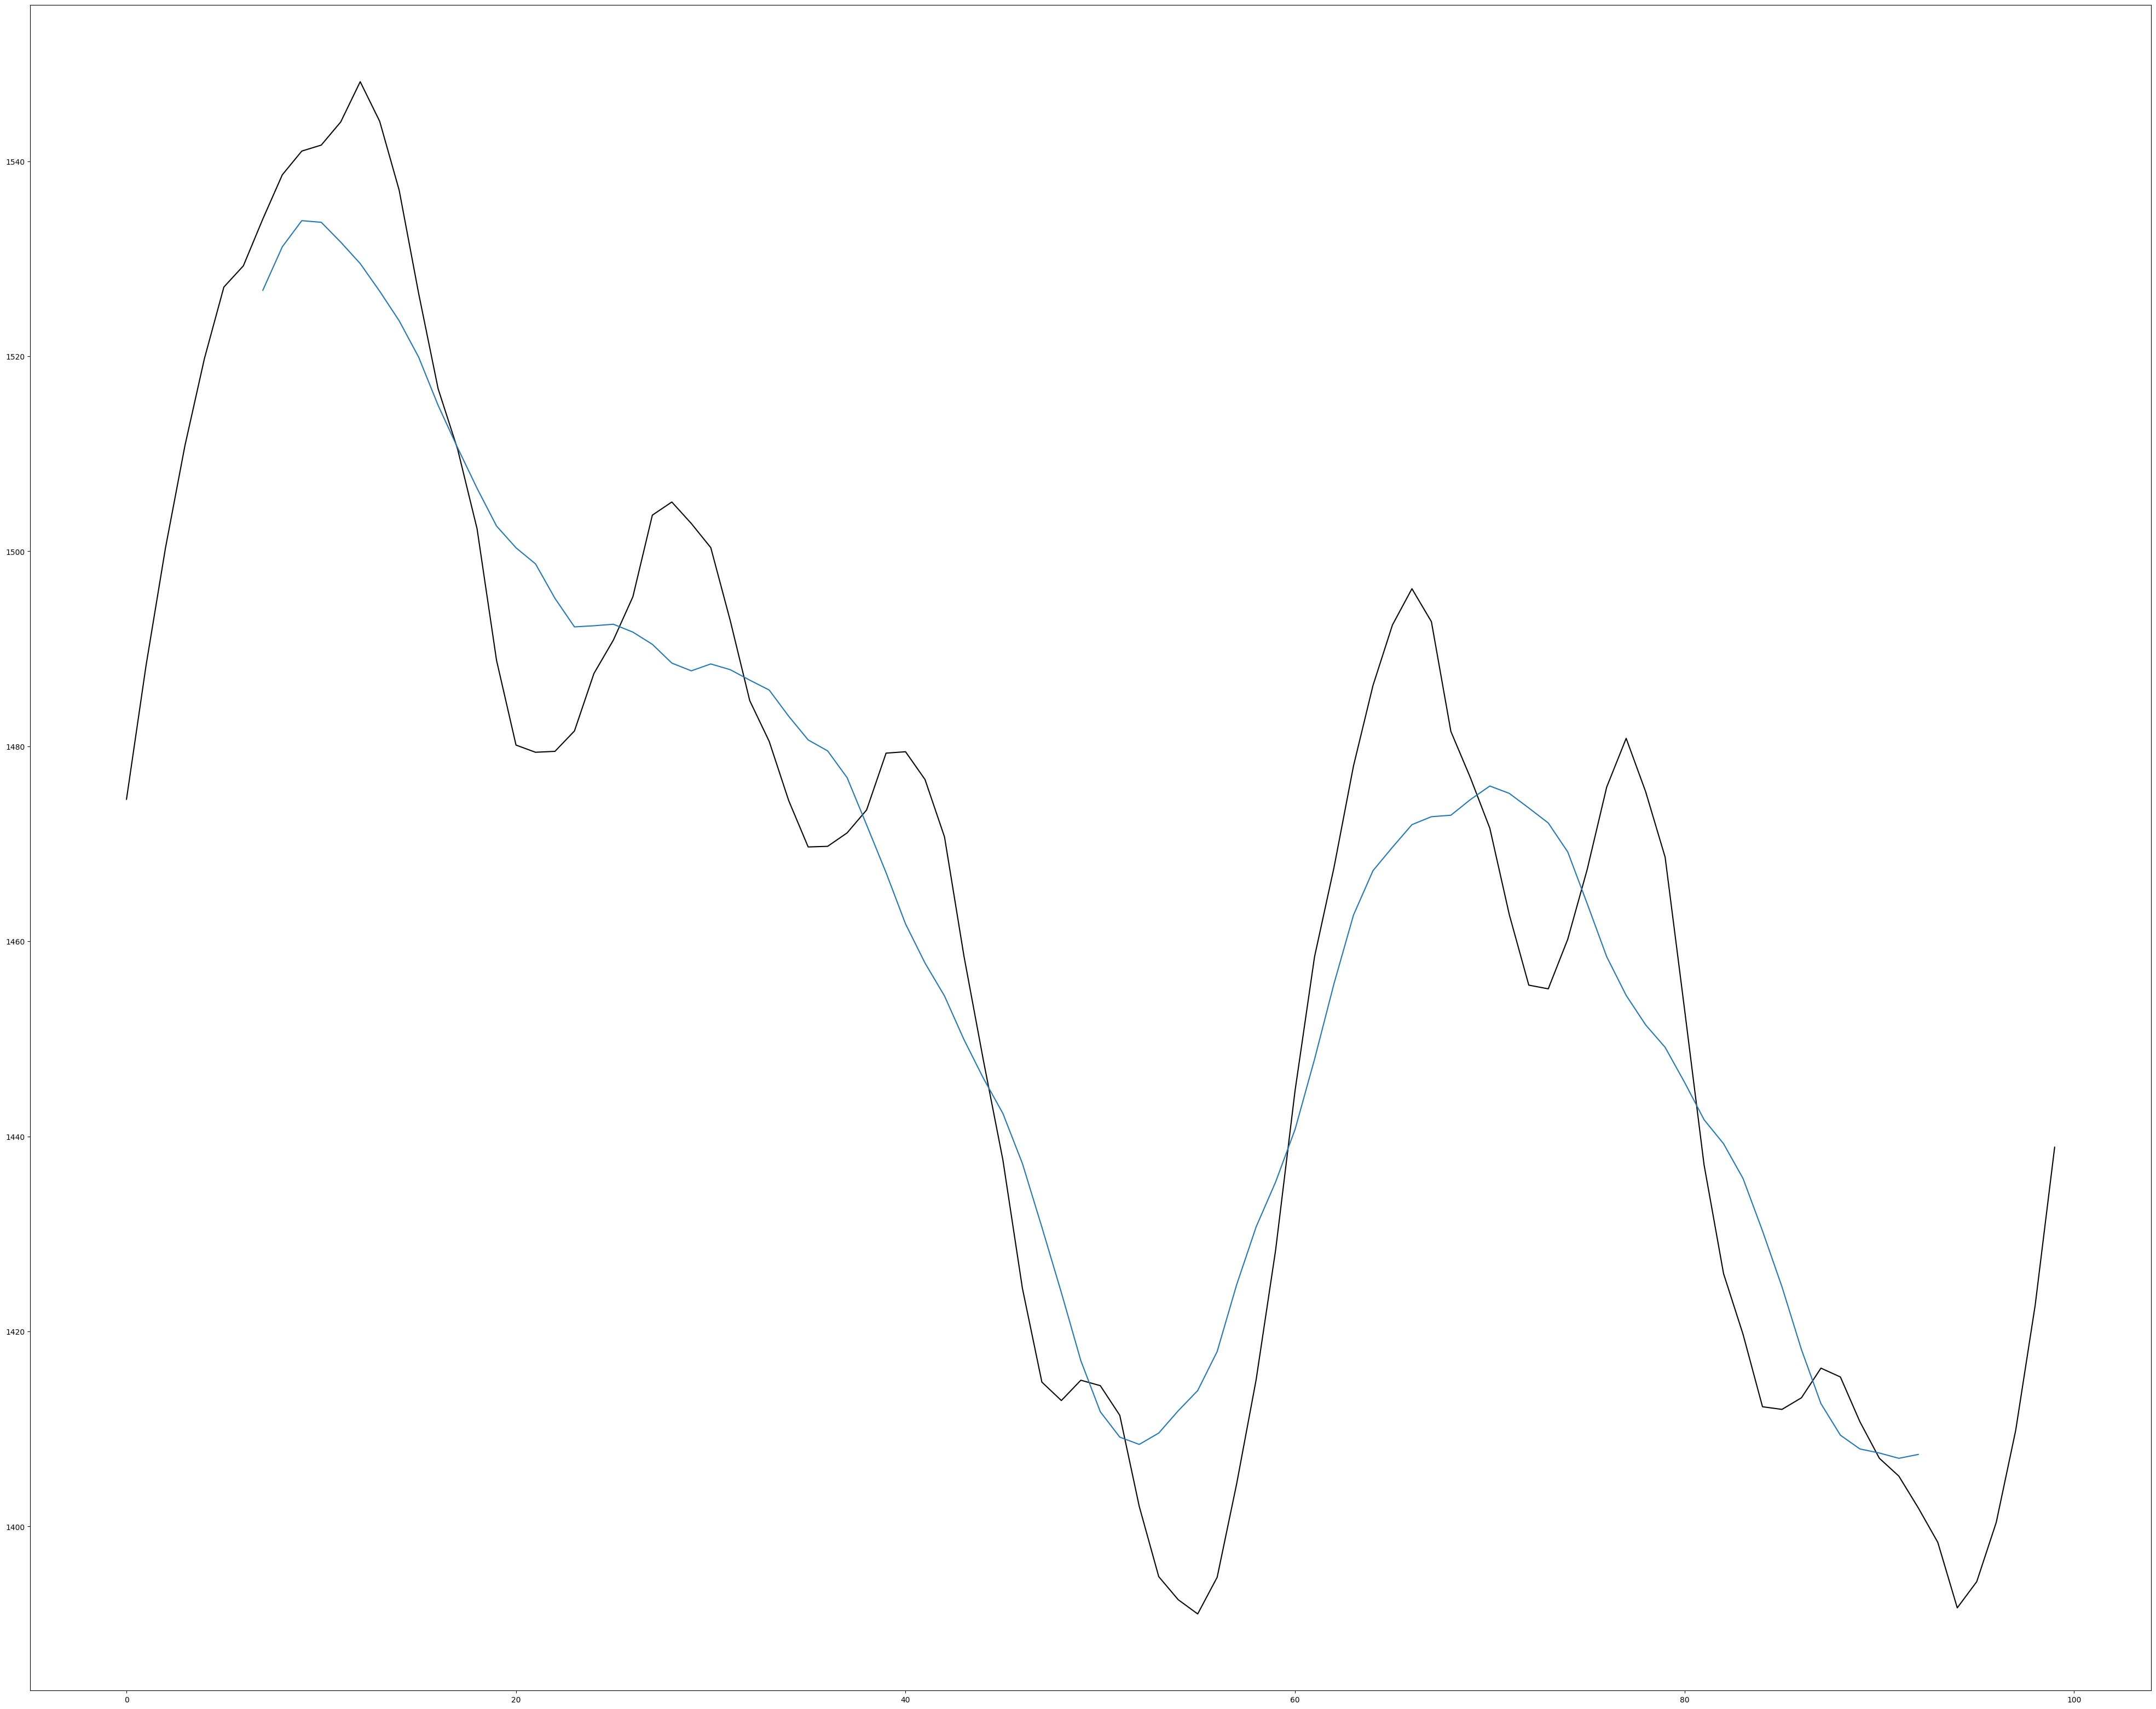

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))
plt.plot(data.index, data['s_close'], label='s_close', color='black')
plt.plot(data.index, trend, label='trend')

In [7]:
de_savgol_data = data['close'] - data['s_close']

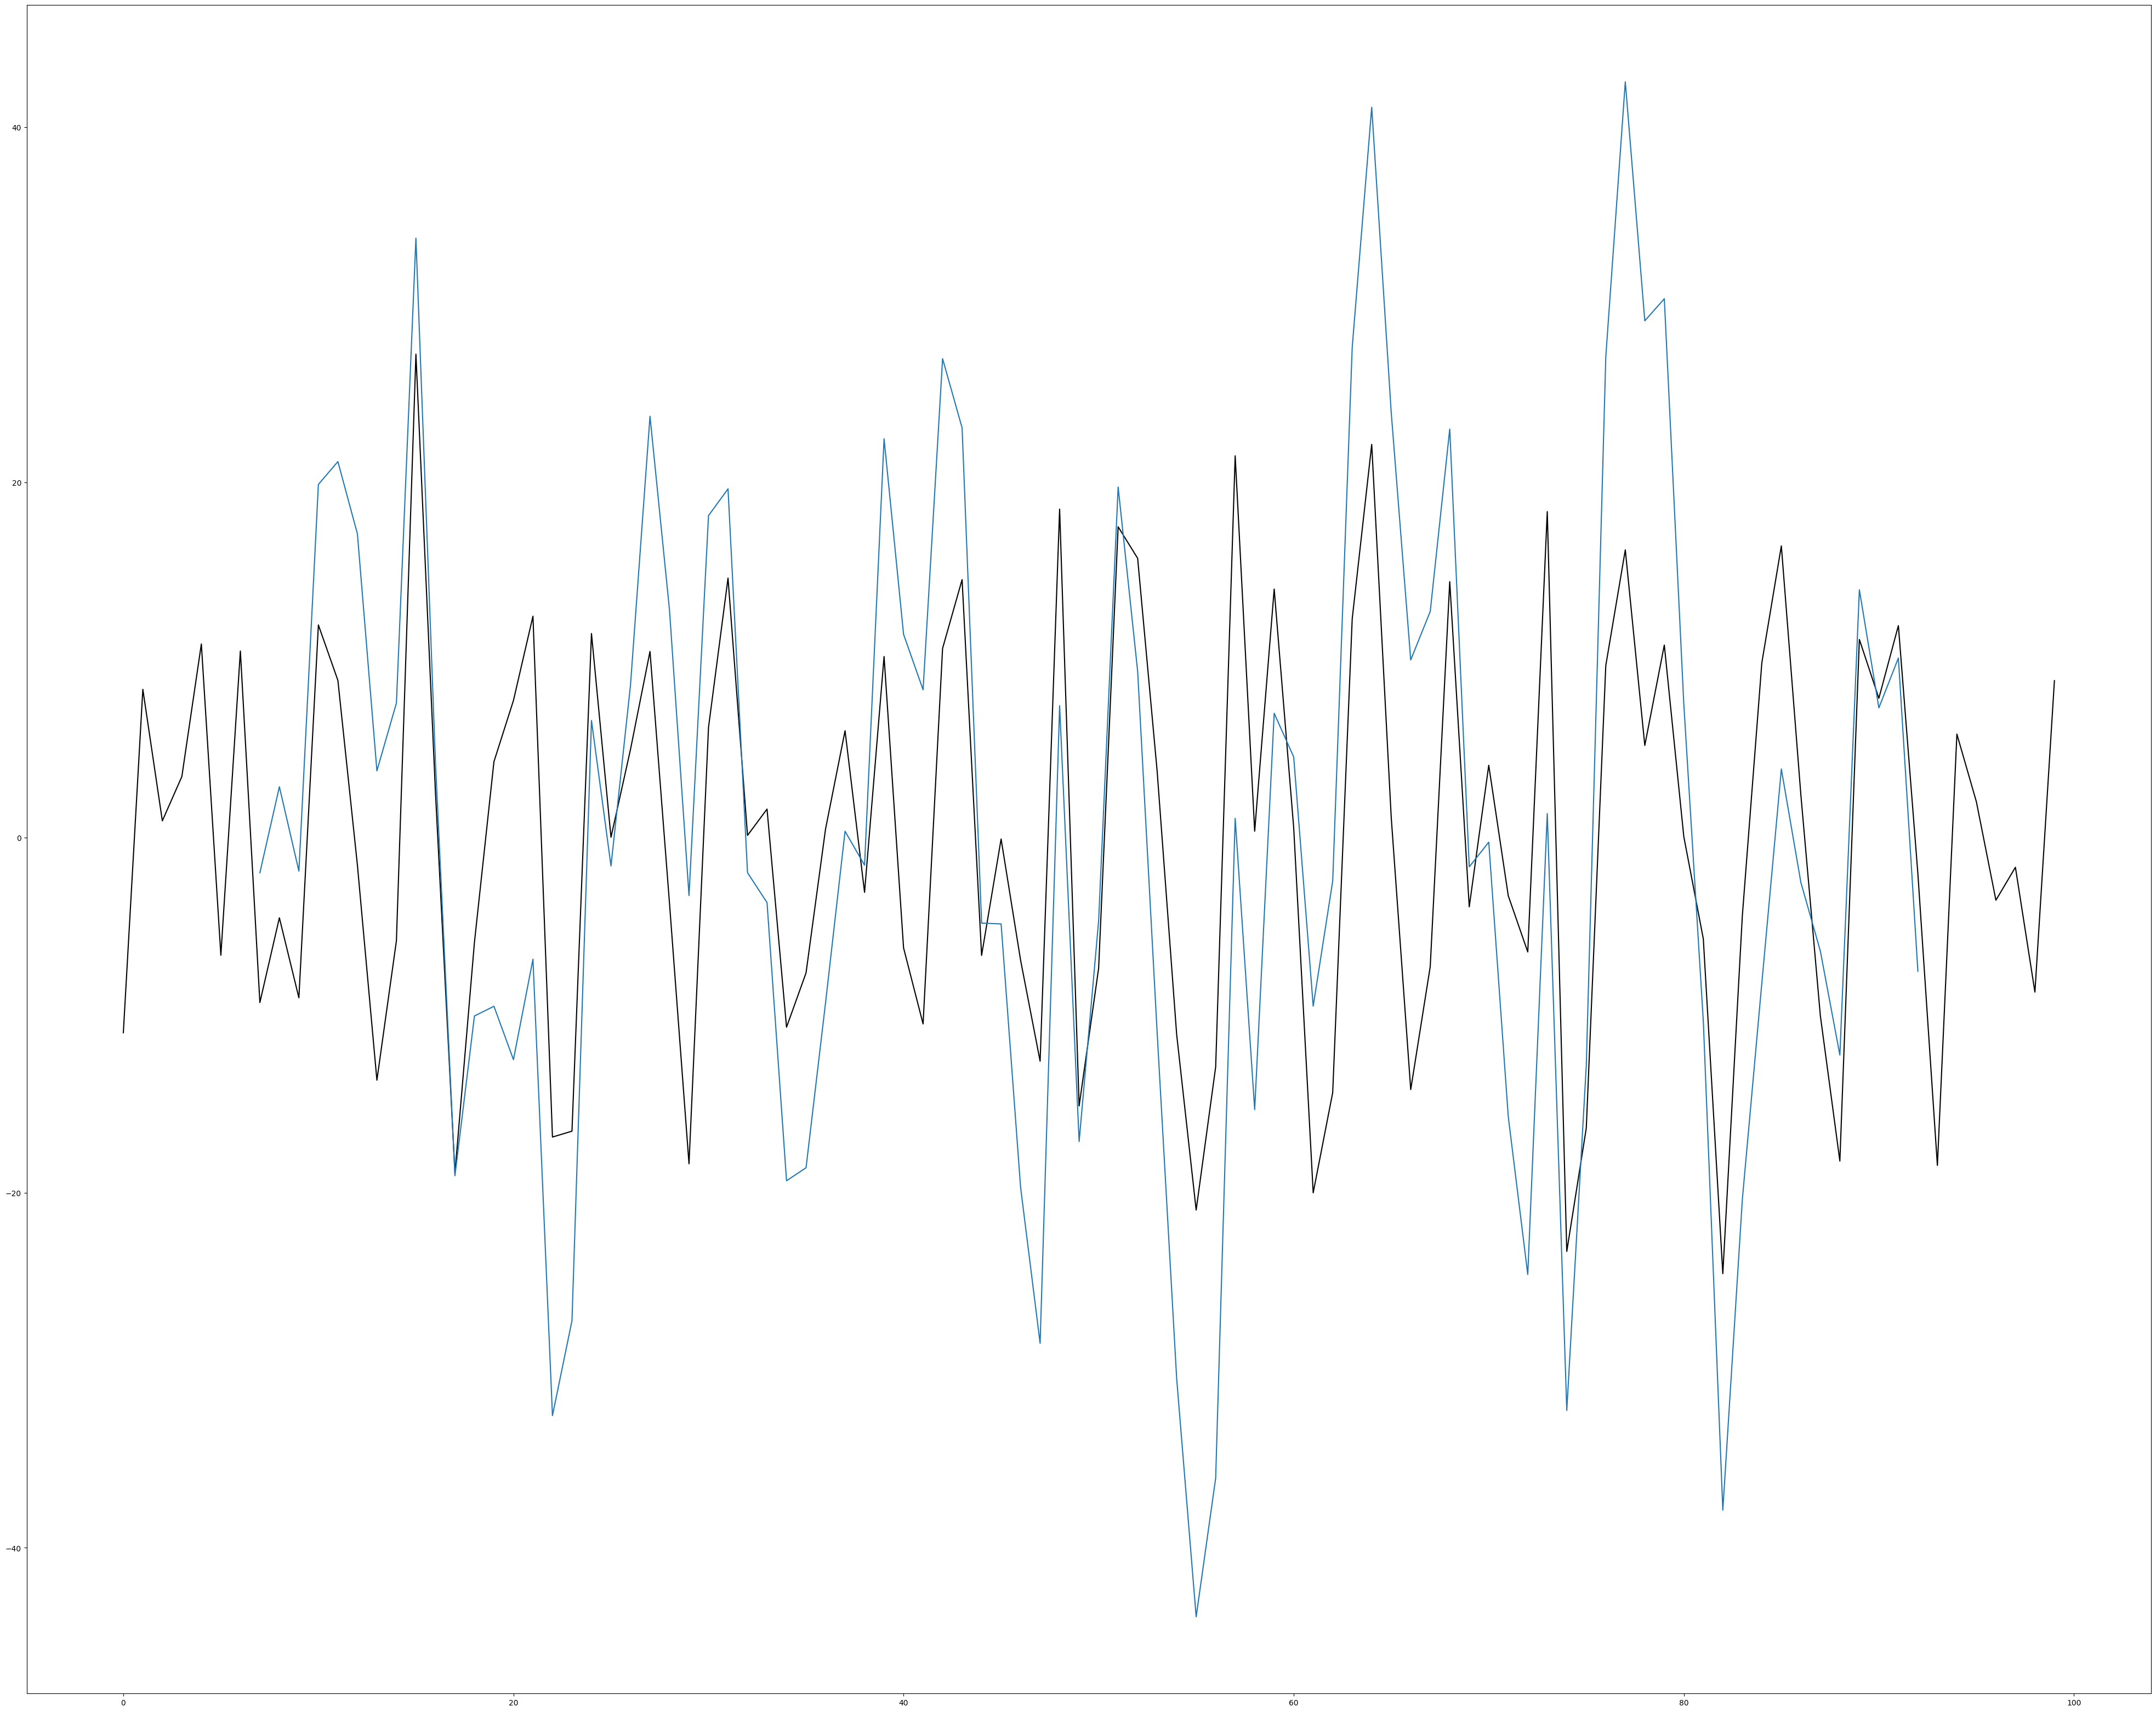

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))
plt.plot(data.index, de_savgol_data, label='de_savgol', color='black')
plt.plot(data.index, detrend, label='detrend')

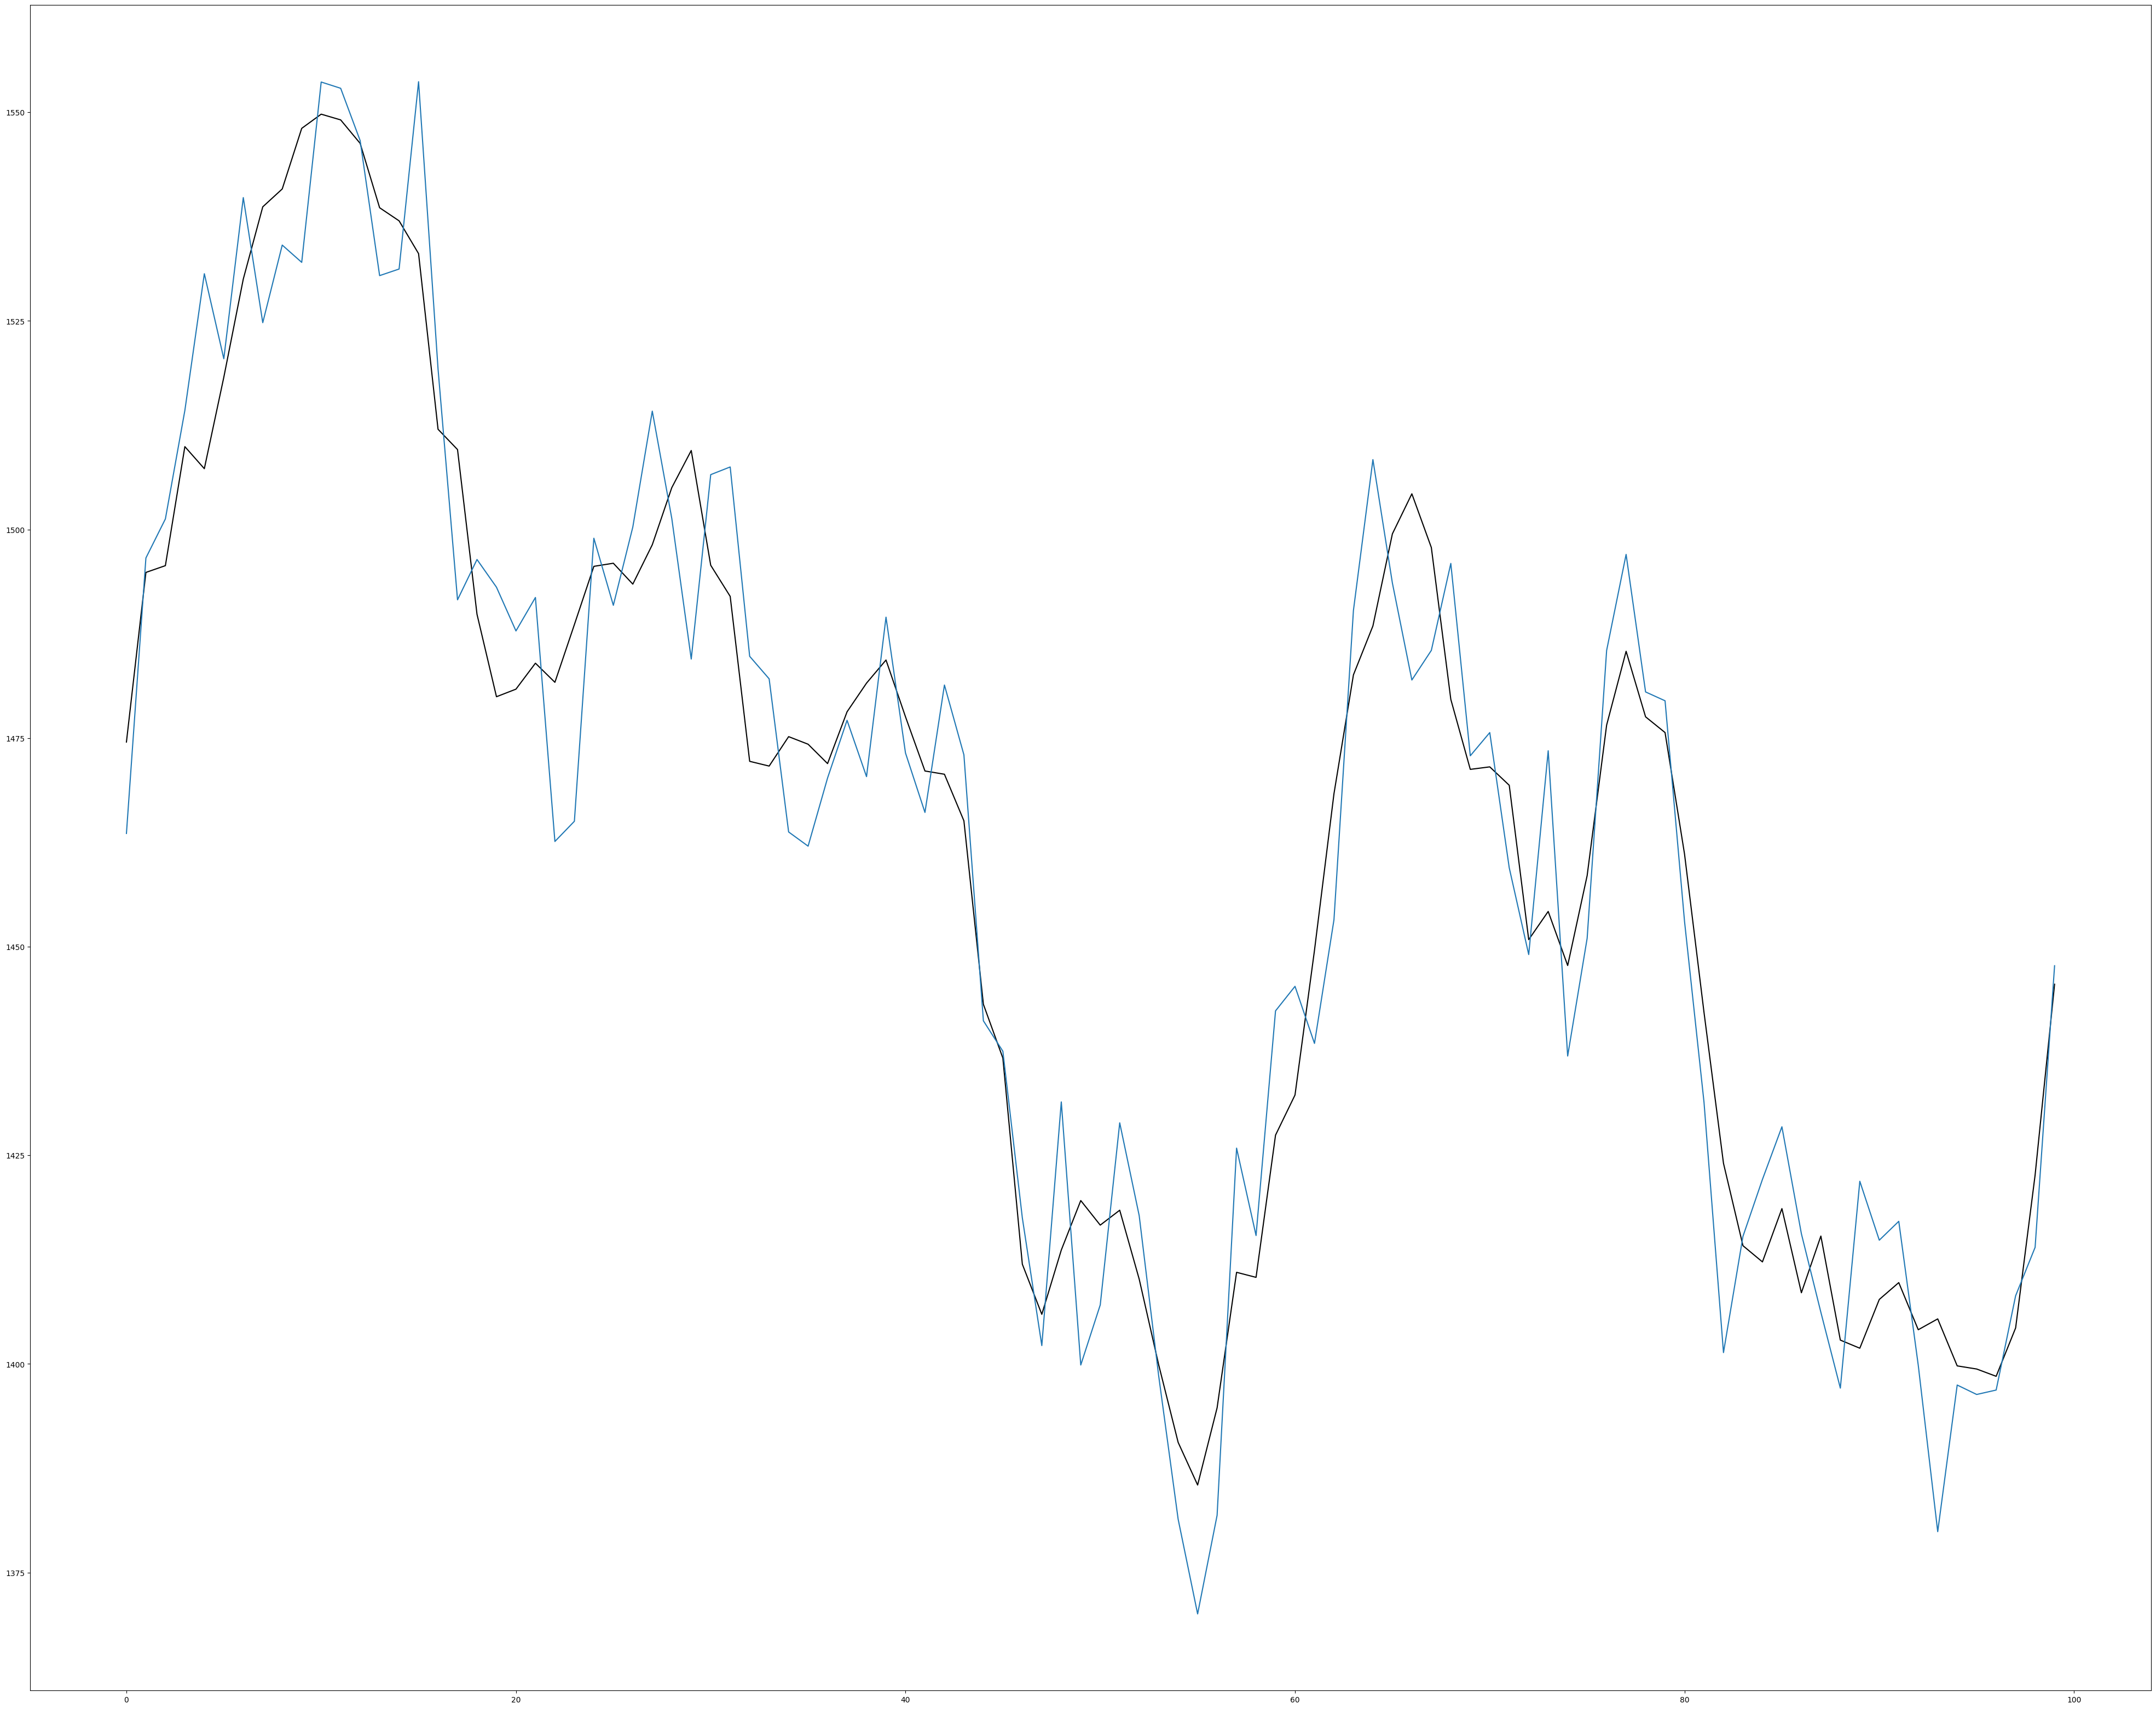

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))
plt.plot(data.index, data['s_close']+season, label='de_savgol', color='black')
plt.plot(data.index, data['close'], label='detrend')

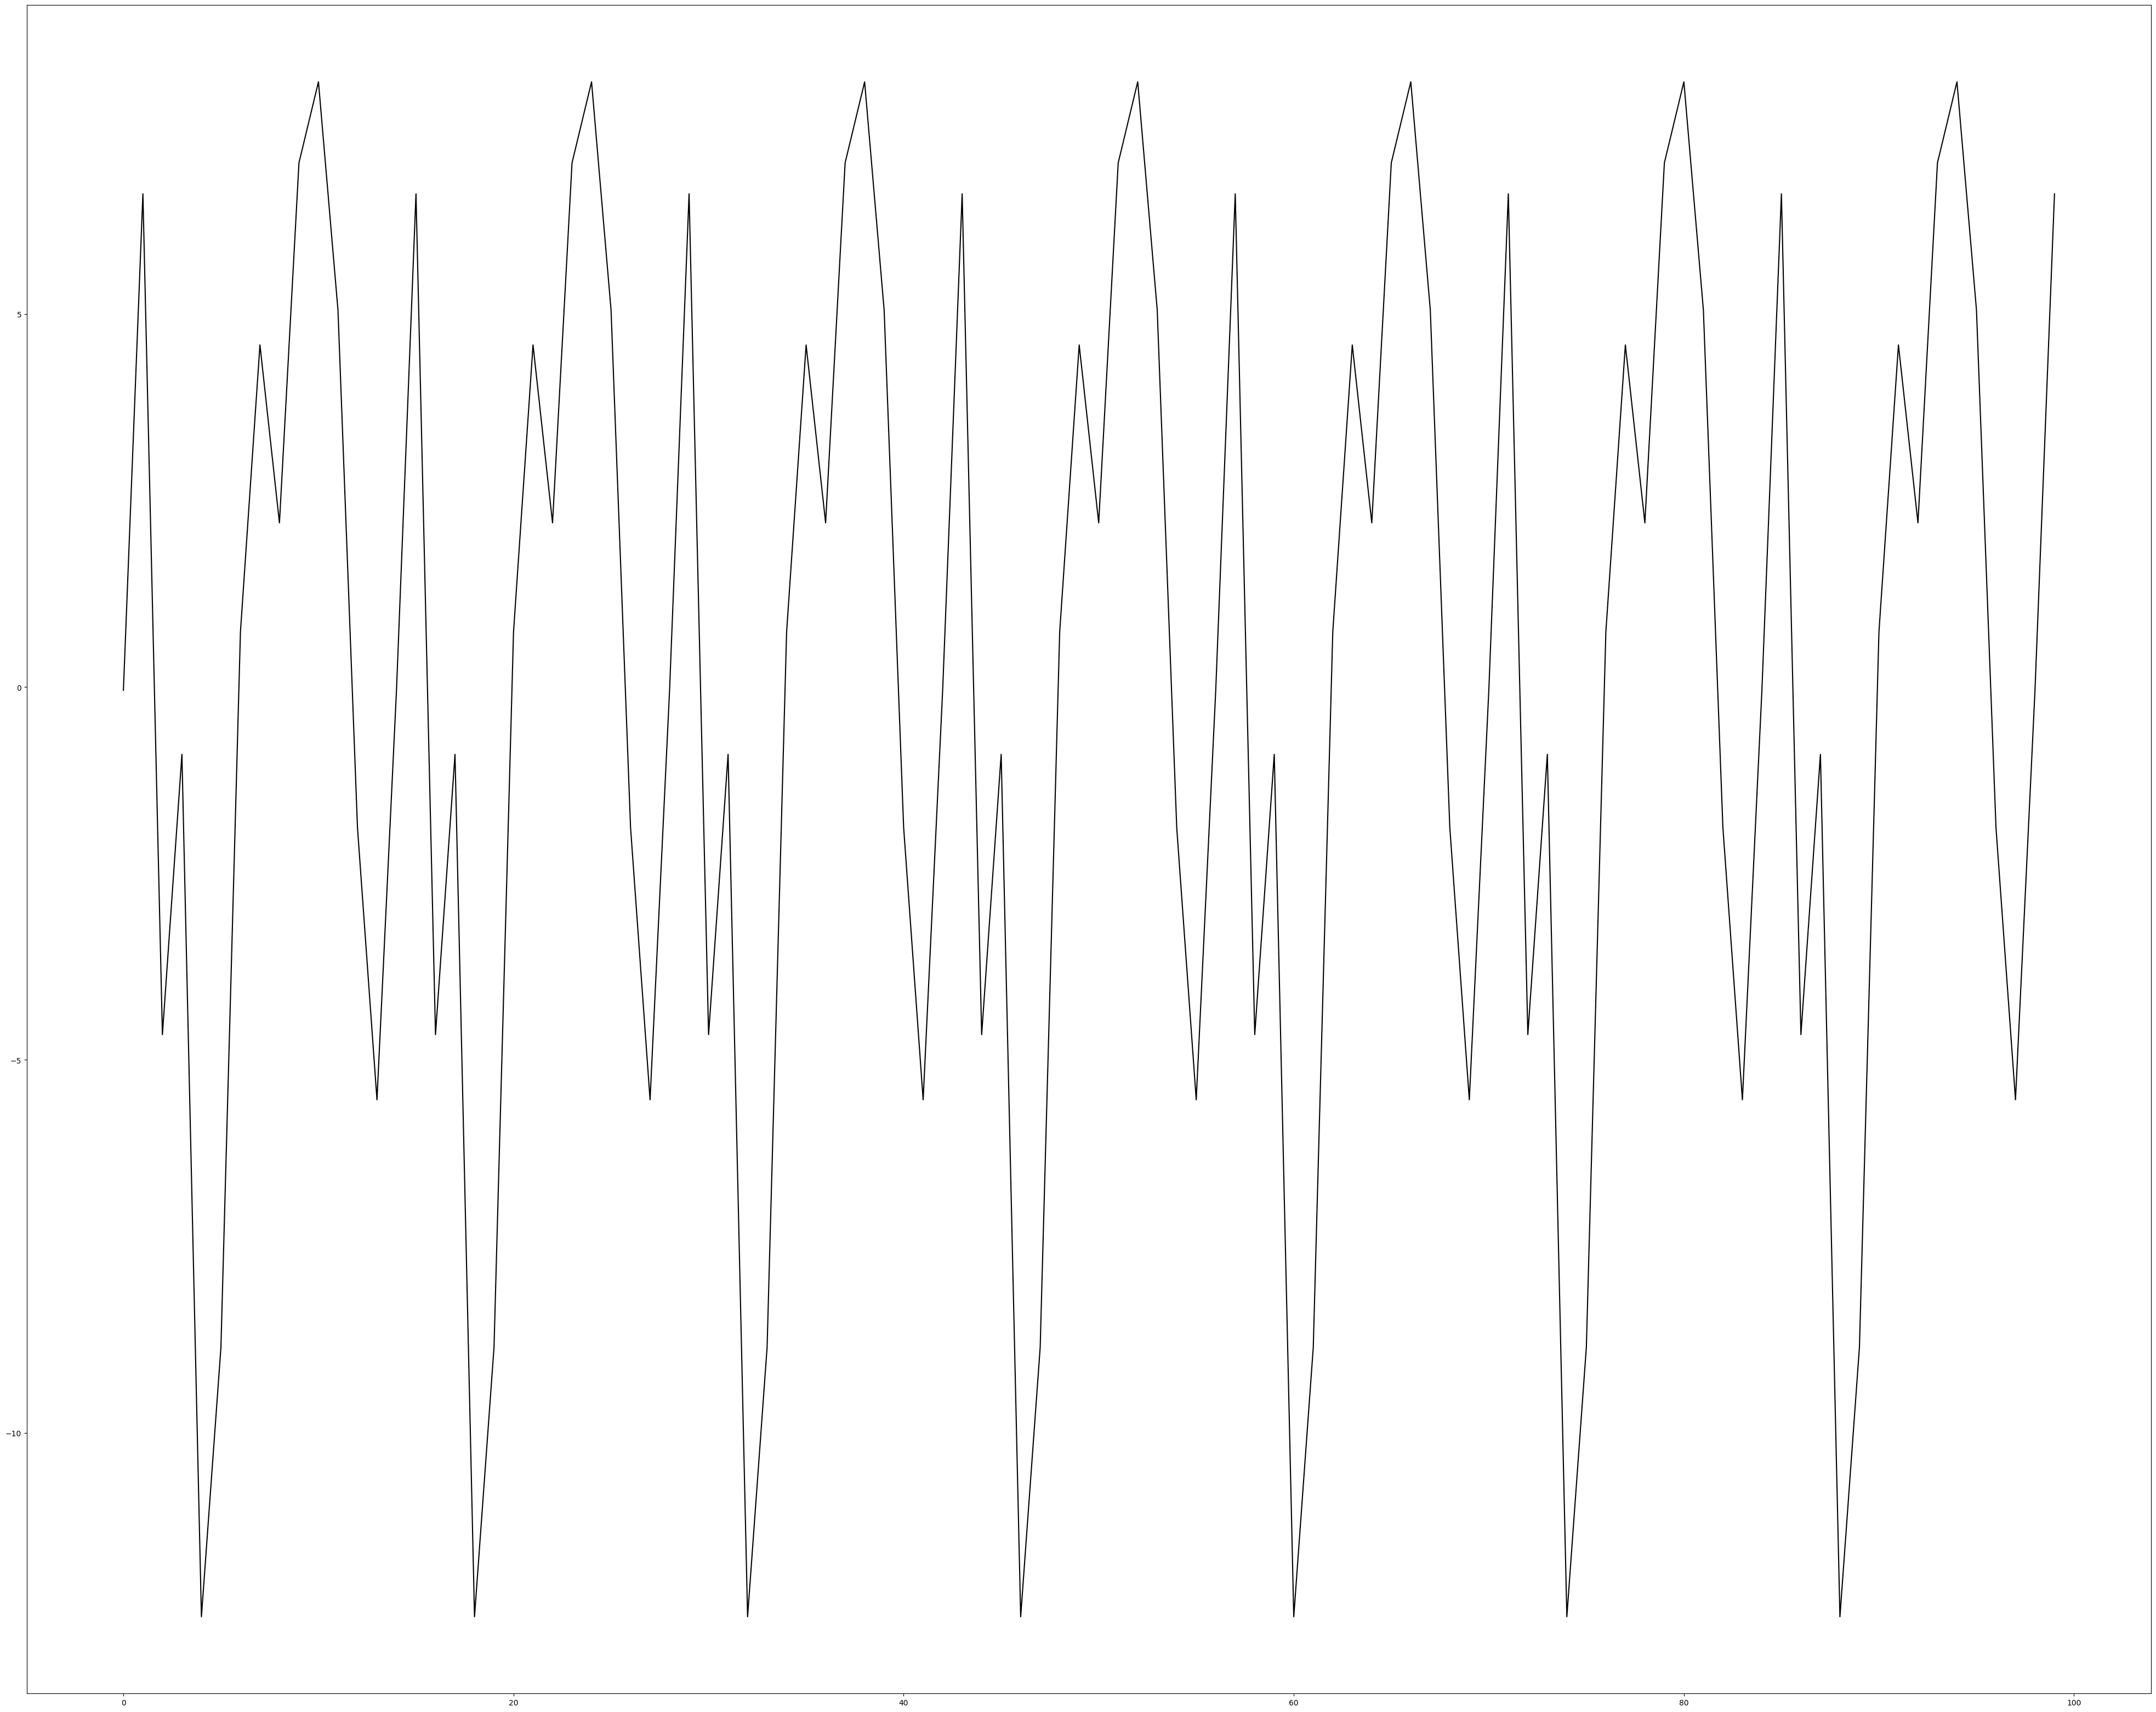

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))
plt.plot(data.index, season, label='season', color='black')

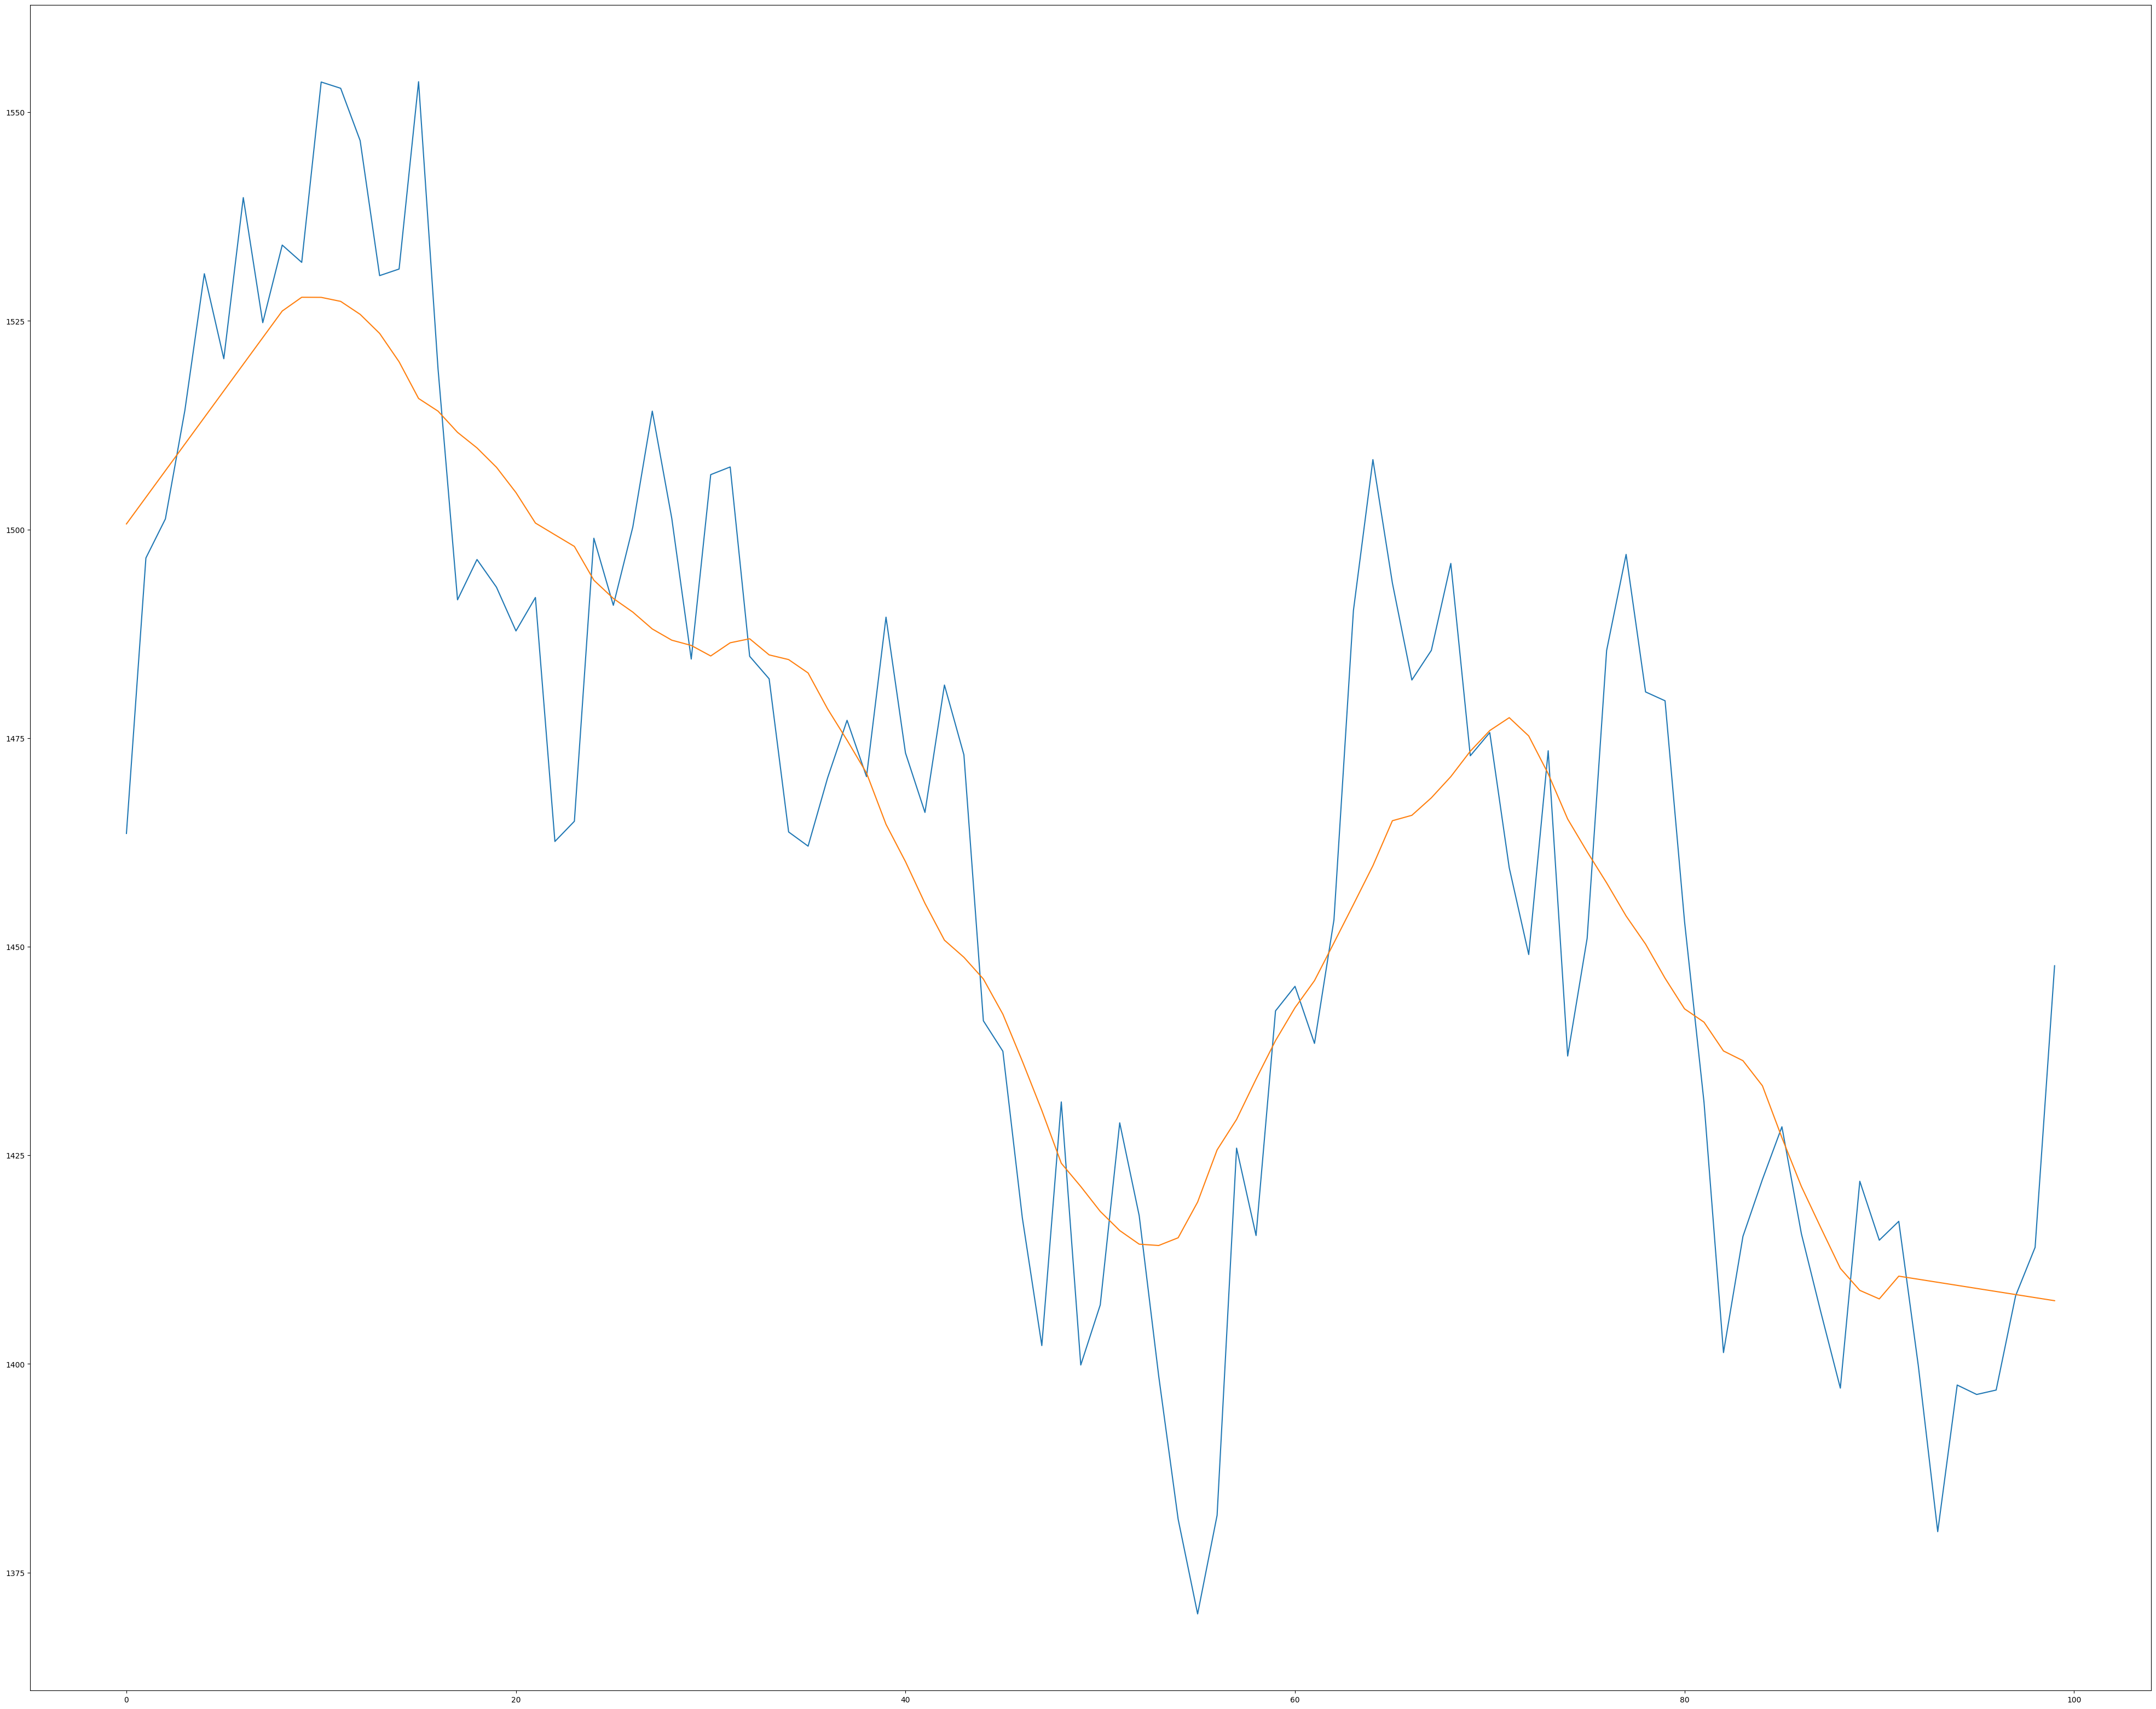

In [11]:
from scipy.signal import savgol_filter

# Apply Savitzky-Golay filter
window_length = 17  # Window length (must be odd)
polyorder = 1      # Polynomial order

test_savgol = savgol_filter(data['close'], window_length, polyorder)

import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))
plt.plot(data.index, data['close'], label='close')
plt.plot(data.index, test_savgol, label='s_close')

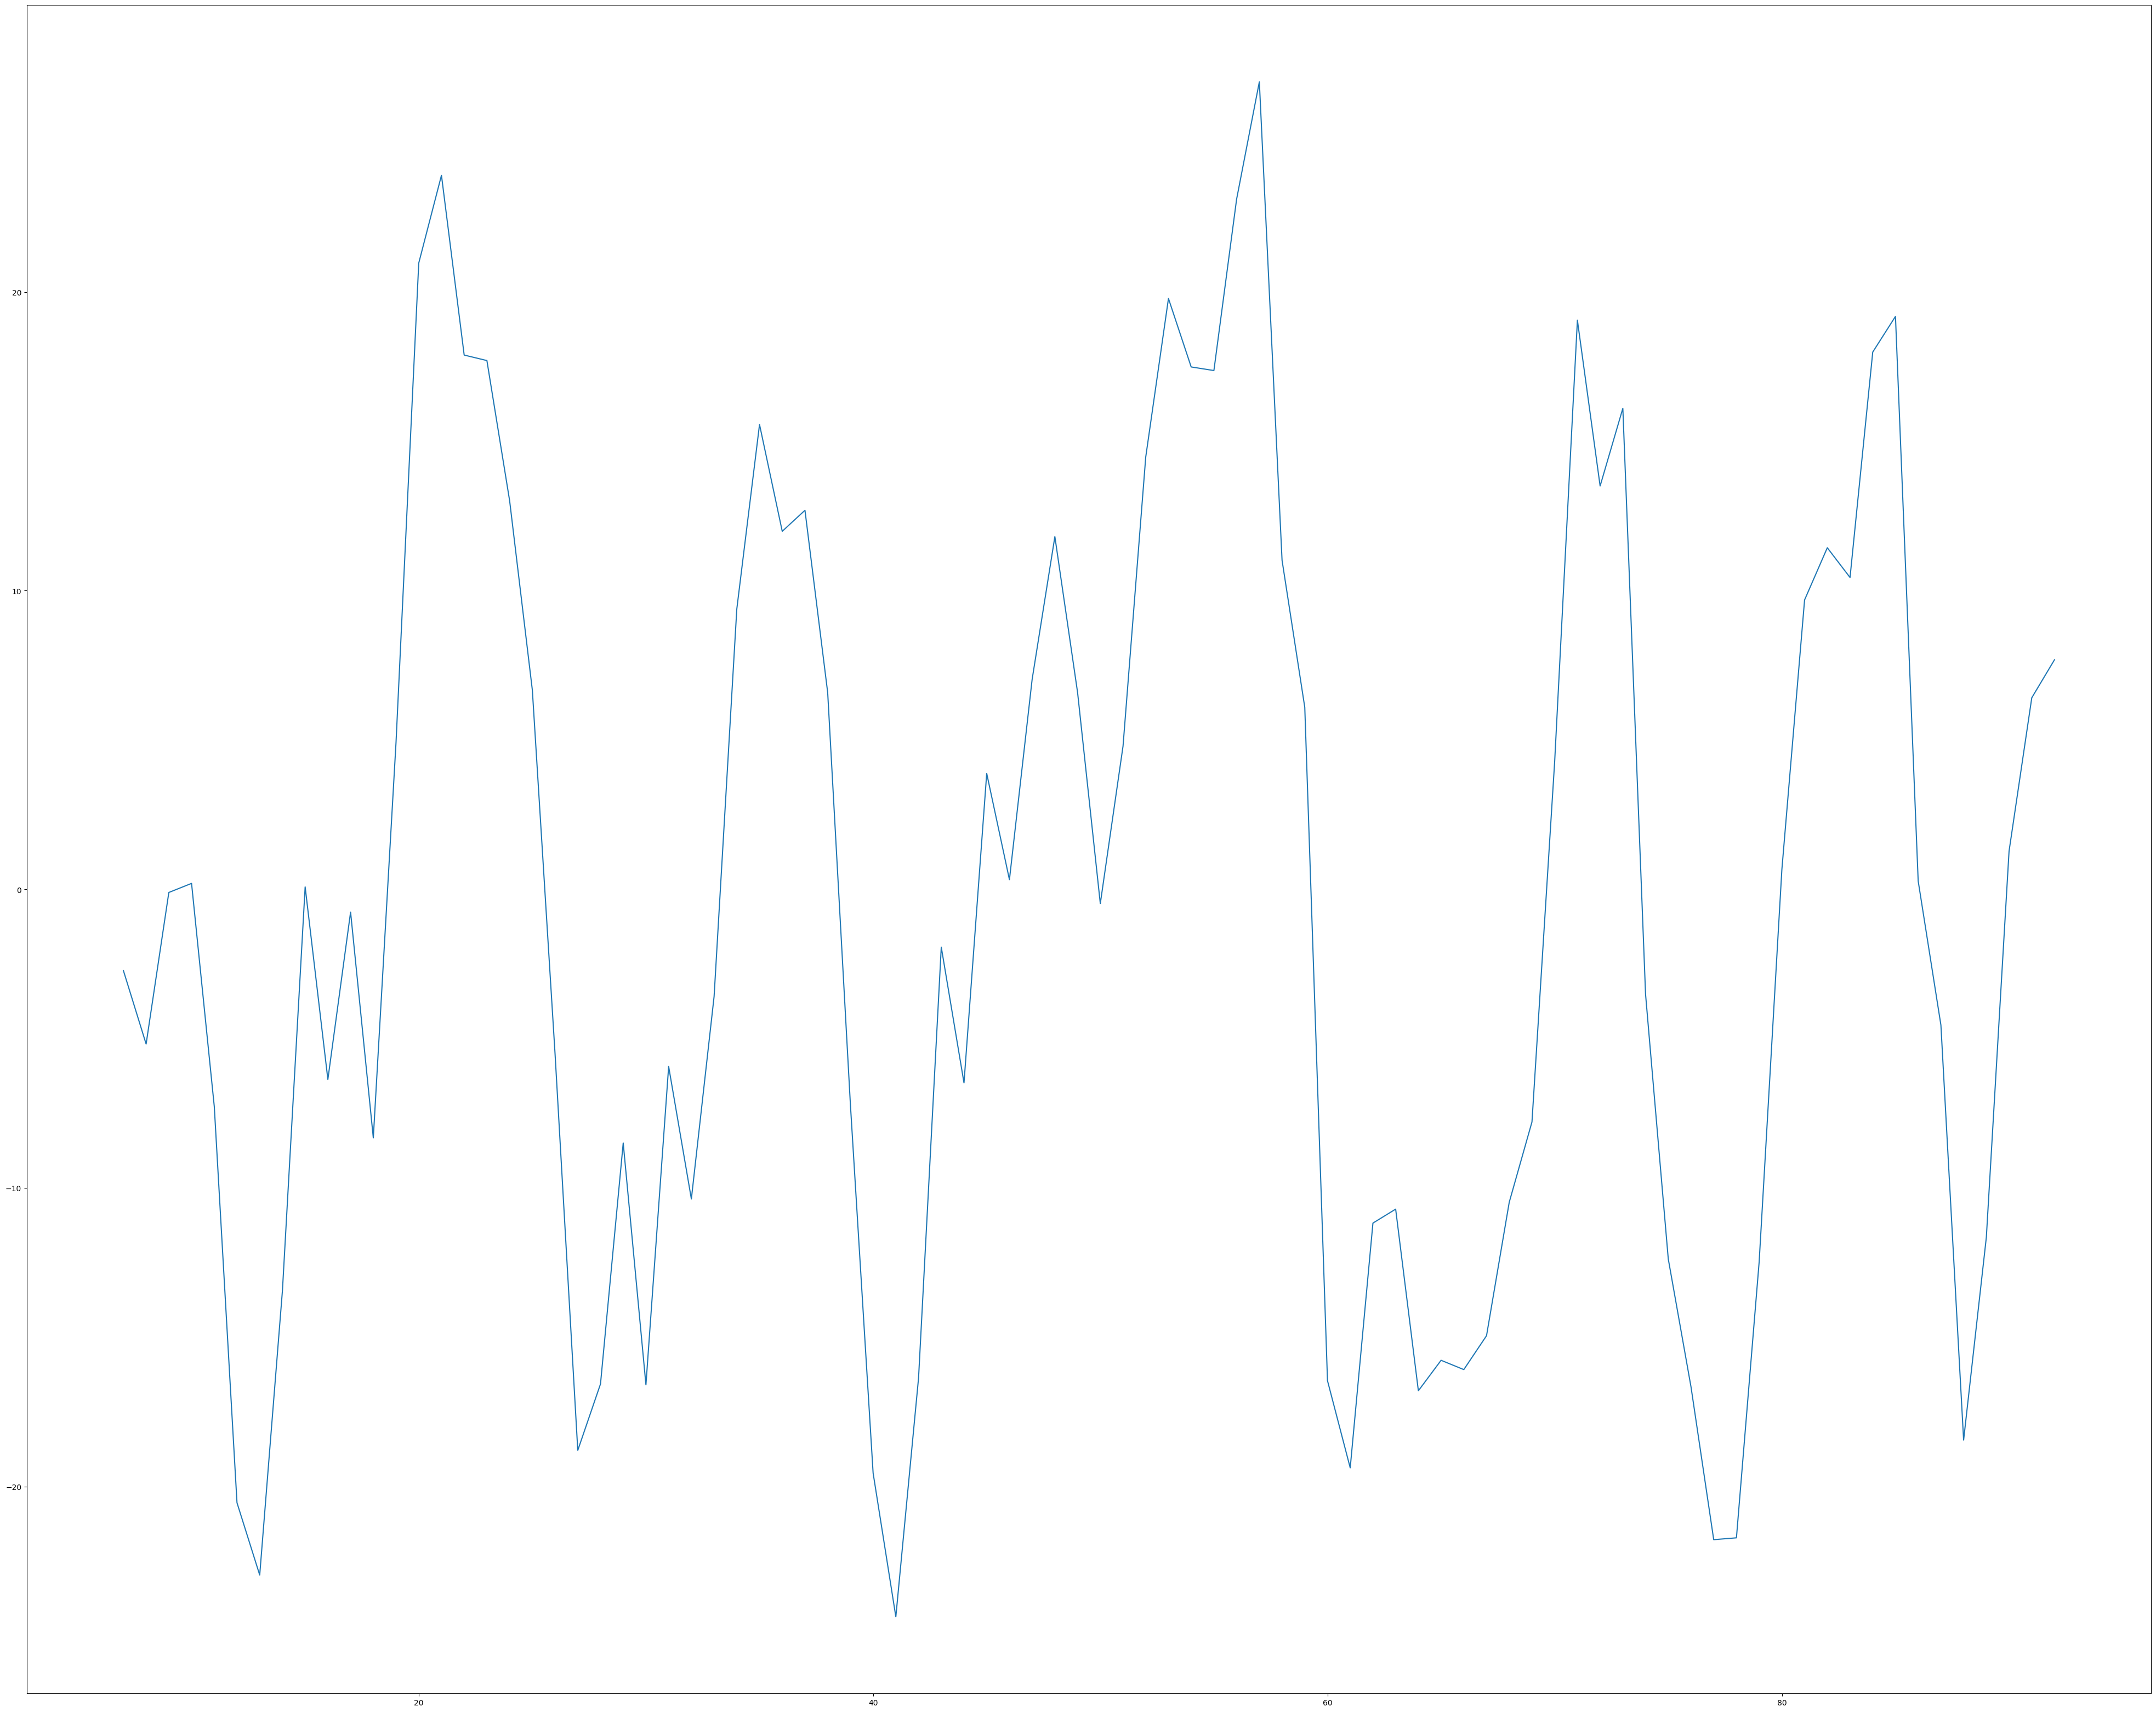

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))
plt.plot(data.index, de_savgol_data-residual, label='close')

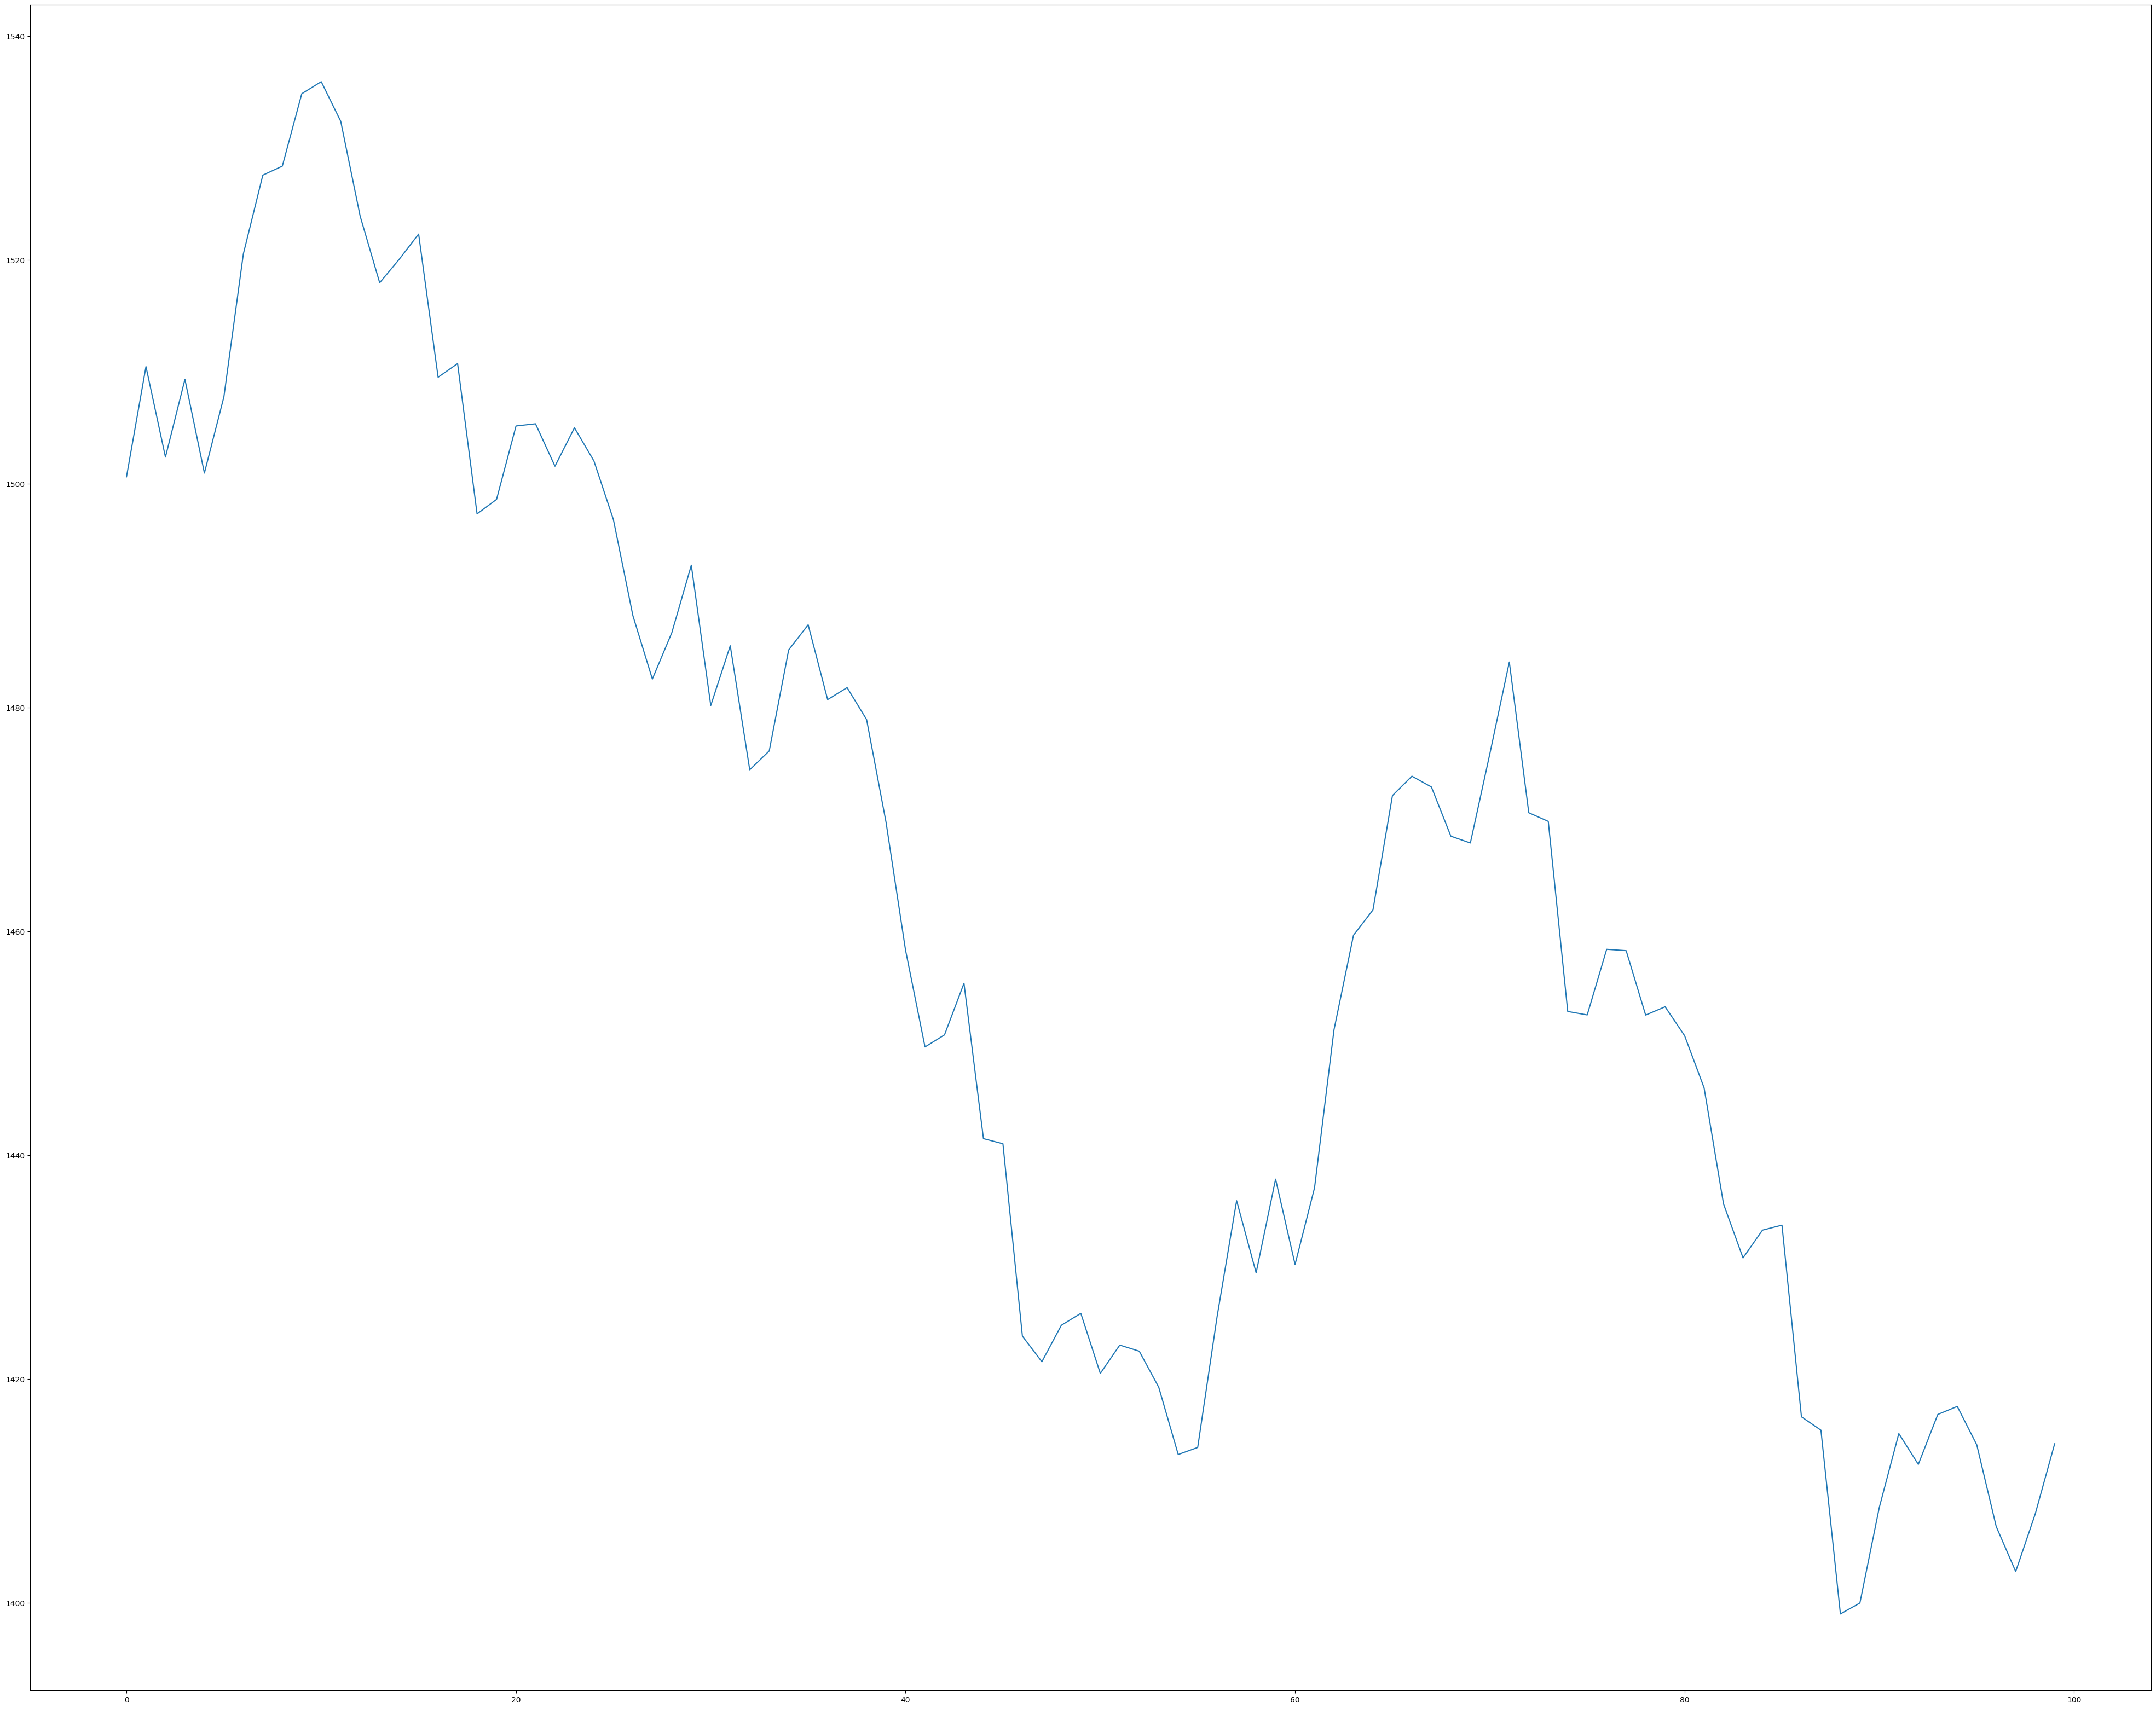

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))
plt.plot(data.index, test_savgol+season, label='close')

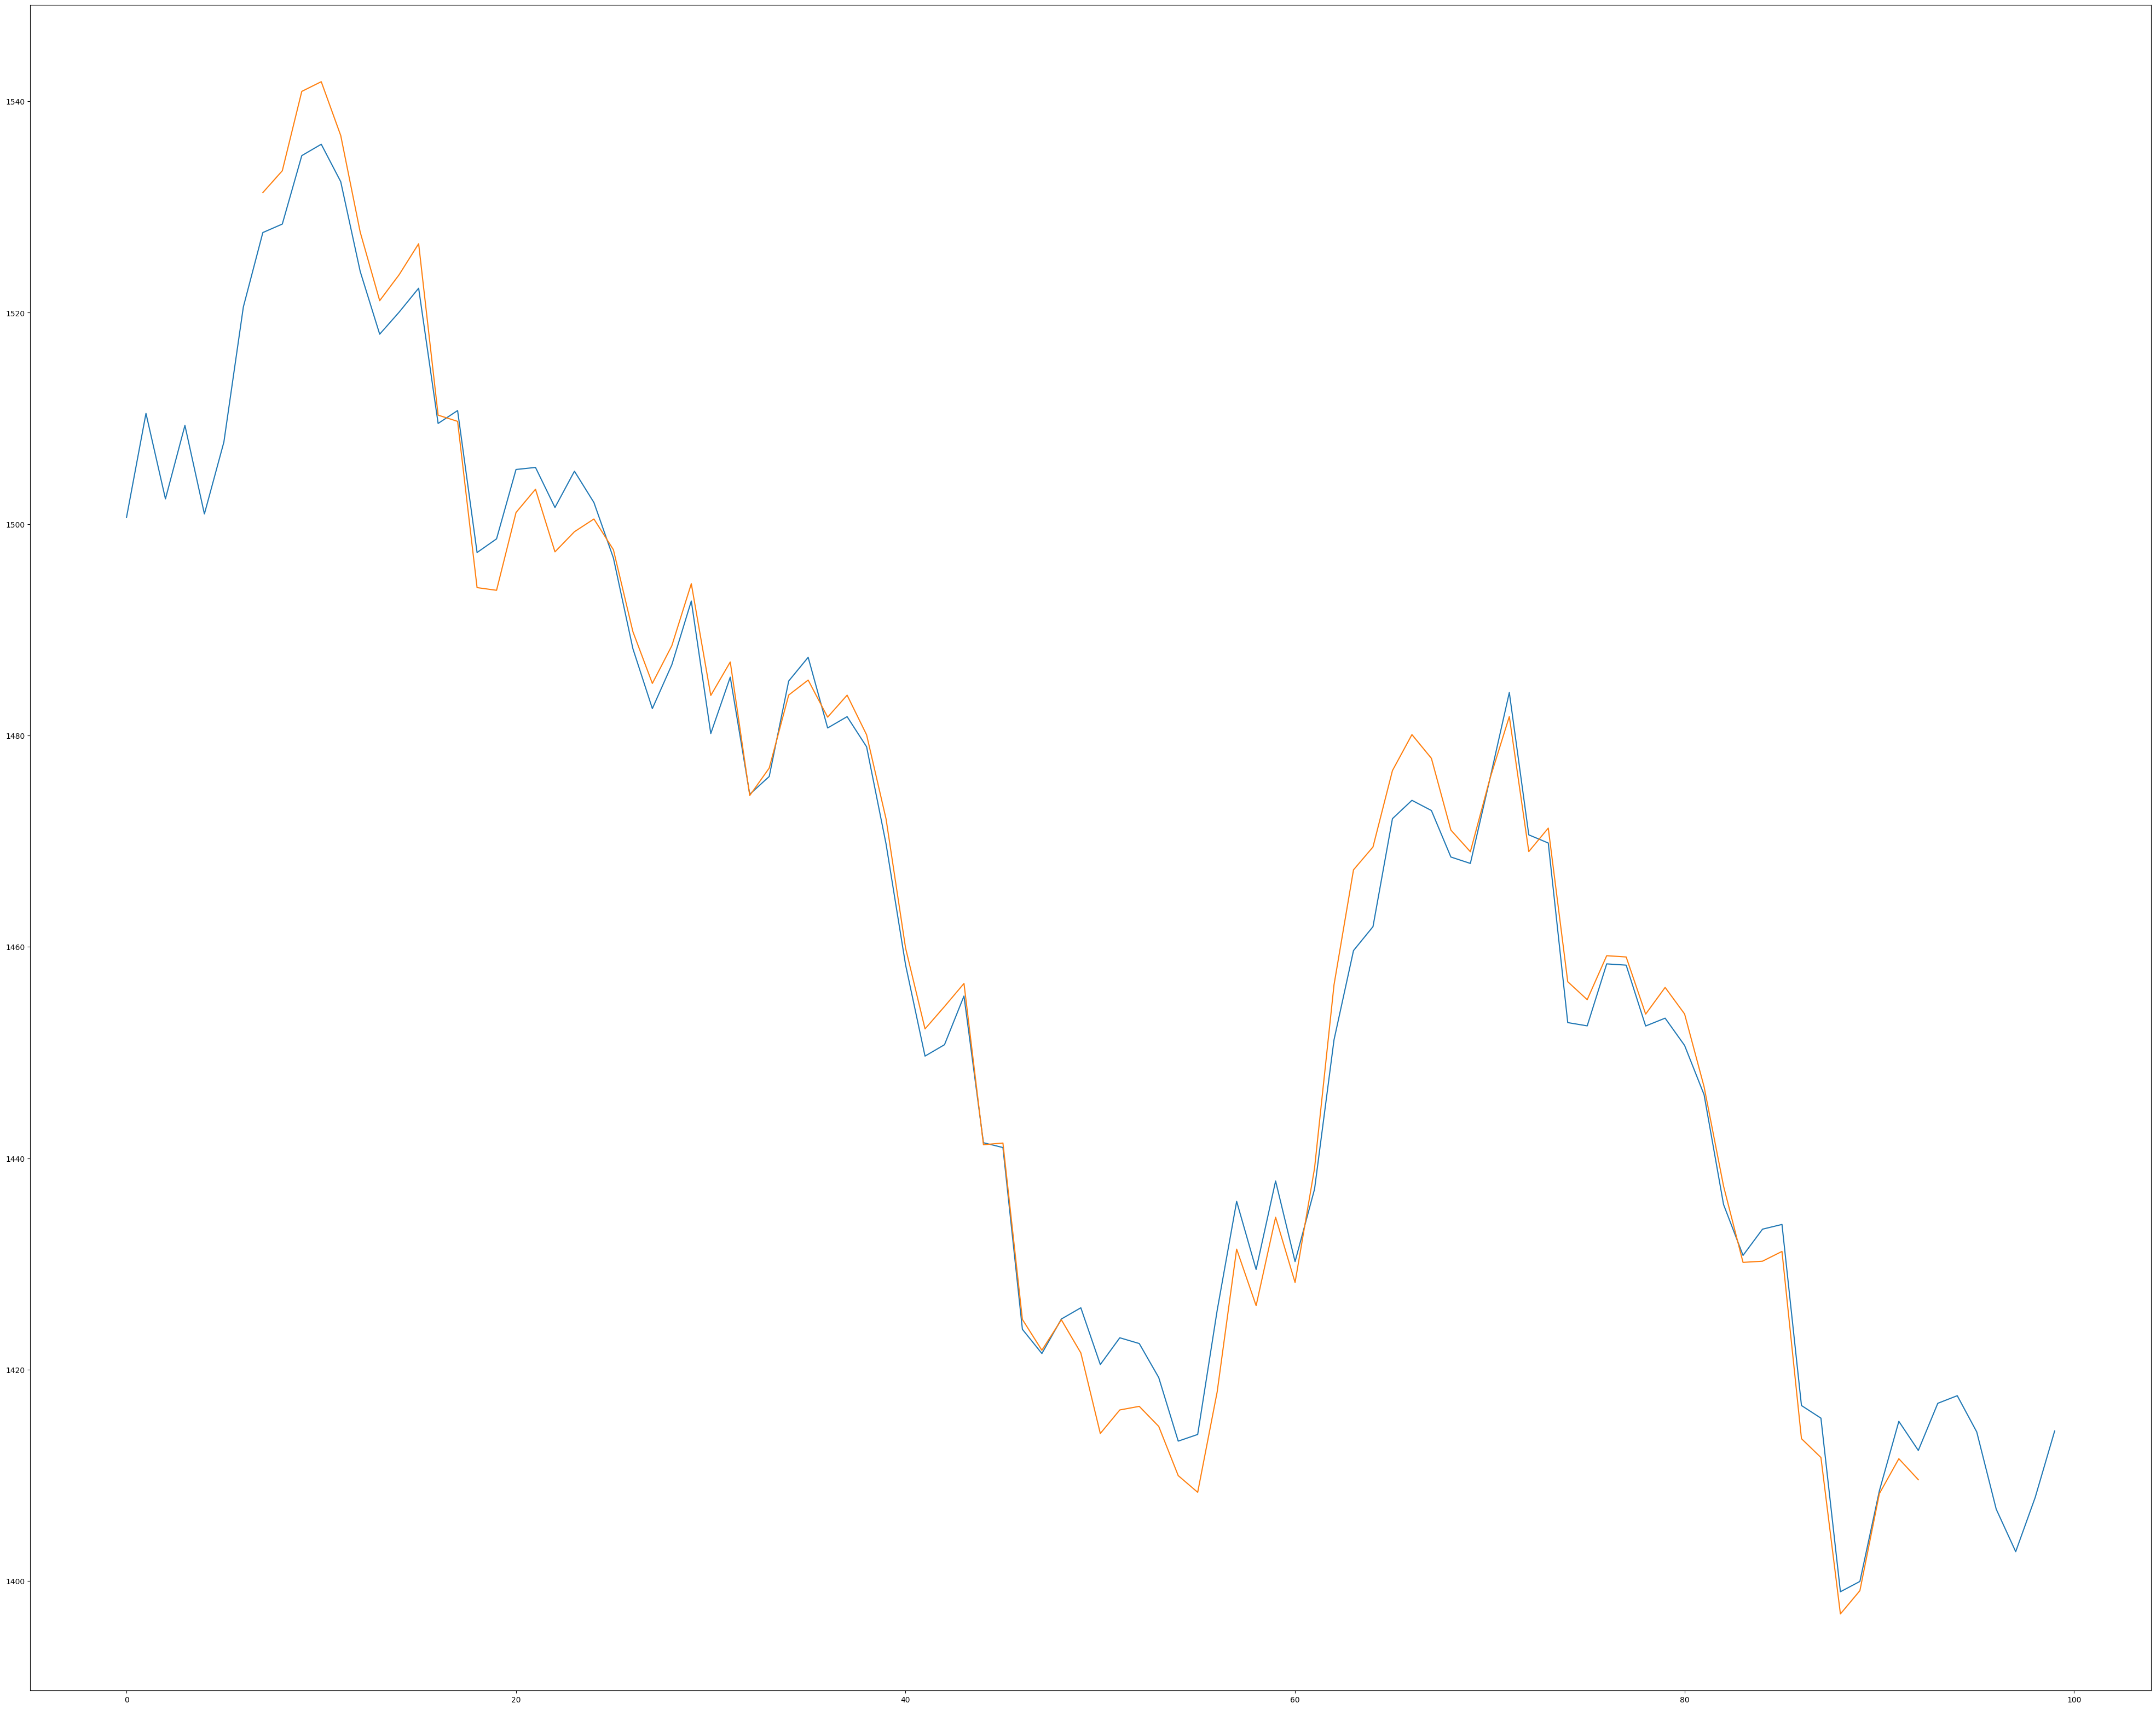

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))
plt.plot(data.index, test_savgol+season, label='close')
plt.plot(data.index, data['close']-residual, label='close')

In [15]:
test_savgol = savgol_filter(data['close'], window_length, polyorder)

In [16]:
import statsmodels.api as sm
import numpy as np
from sklearn.linear_model import LinearRegression

def loess_forecast(data, frac, n_forecast):
    #lowess = sm.nonparametric.lowess(data, np.arange(len(data)), frac=frac)
    #trend_loess = lowess[:, 1]
    X = np.arange(len(data))
    model = LinearRegression().fit(X.reshape(-1, 1), data)
    X_forecast = np.arange(len(data), len(data) + n_forecast)
    trend_forecast = model.predict(X_forecast.reshape(-1, 1))
    return trend_forecast

# Example usage
frac = 0.3
n_forecast = 10
trend_forecast = loess_forecast(test_savgol[-10:], frac, n_forecast)


In [17]:
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def polynomial_regression_forecast(data, degree, n_forecast):
    X = np.arange(len(data)).reshape(-1, 1)
    
    # Fit Polynomial Regression
    poly_features = PolynomialFeatures(degree=degree)
    X_poly = poly_features.fit_transform(X)
    poly_model = LinearRegression().fit(X_poly, data)
    
    # Forecast future values
    X_forecast = np.arange(len(data), len(data) + n_forecast).reshape(-1, 1)
    X_forecast_poly = poly_features.transform(X_forecast)
    trend_forecast = poly_model.predict(X_forecast_poly)
    
    return trend_forecast

degree = 4  # Degree of the polynomial
n_forecast = 10  # Number of future points to forecast

trend_forecast = polynomial_regression_forecast(test_savgol[-70:-10], degree, n_forecast)

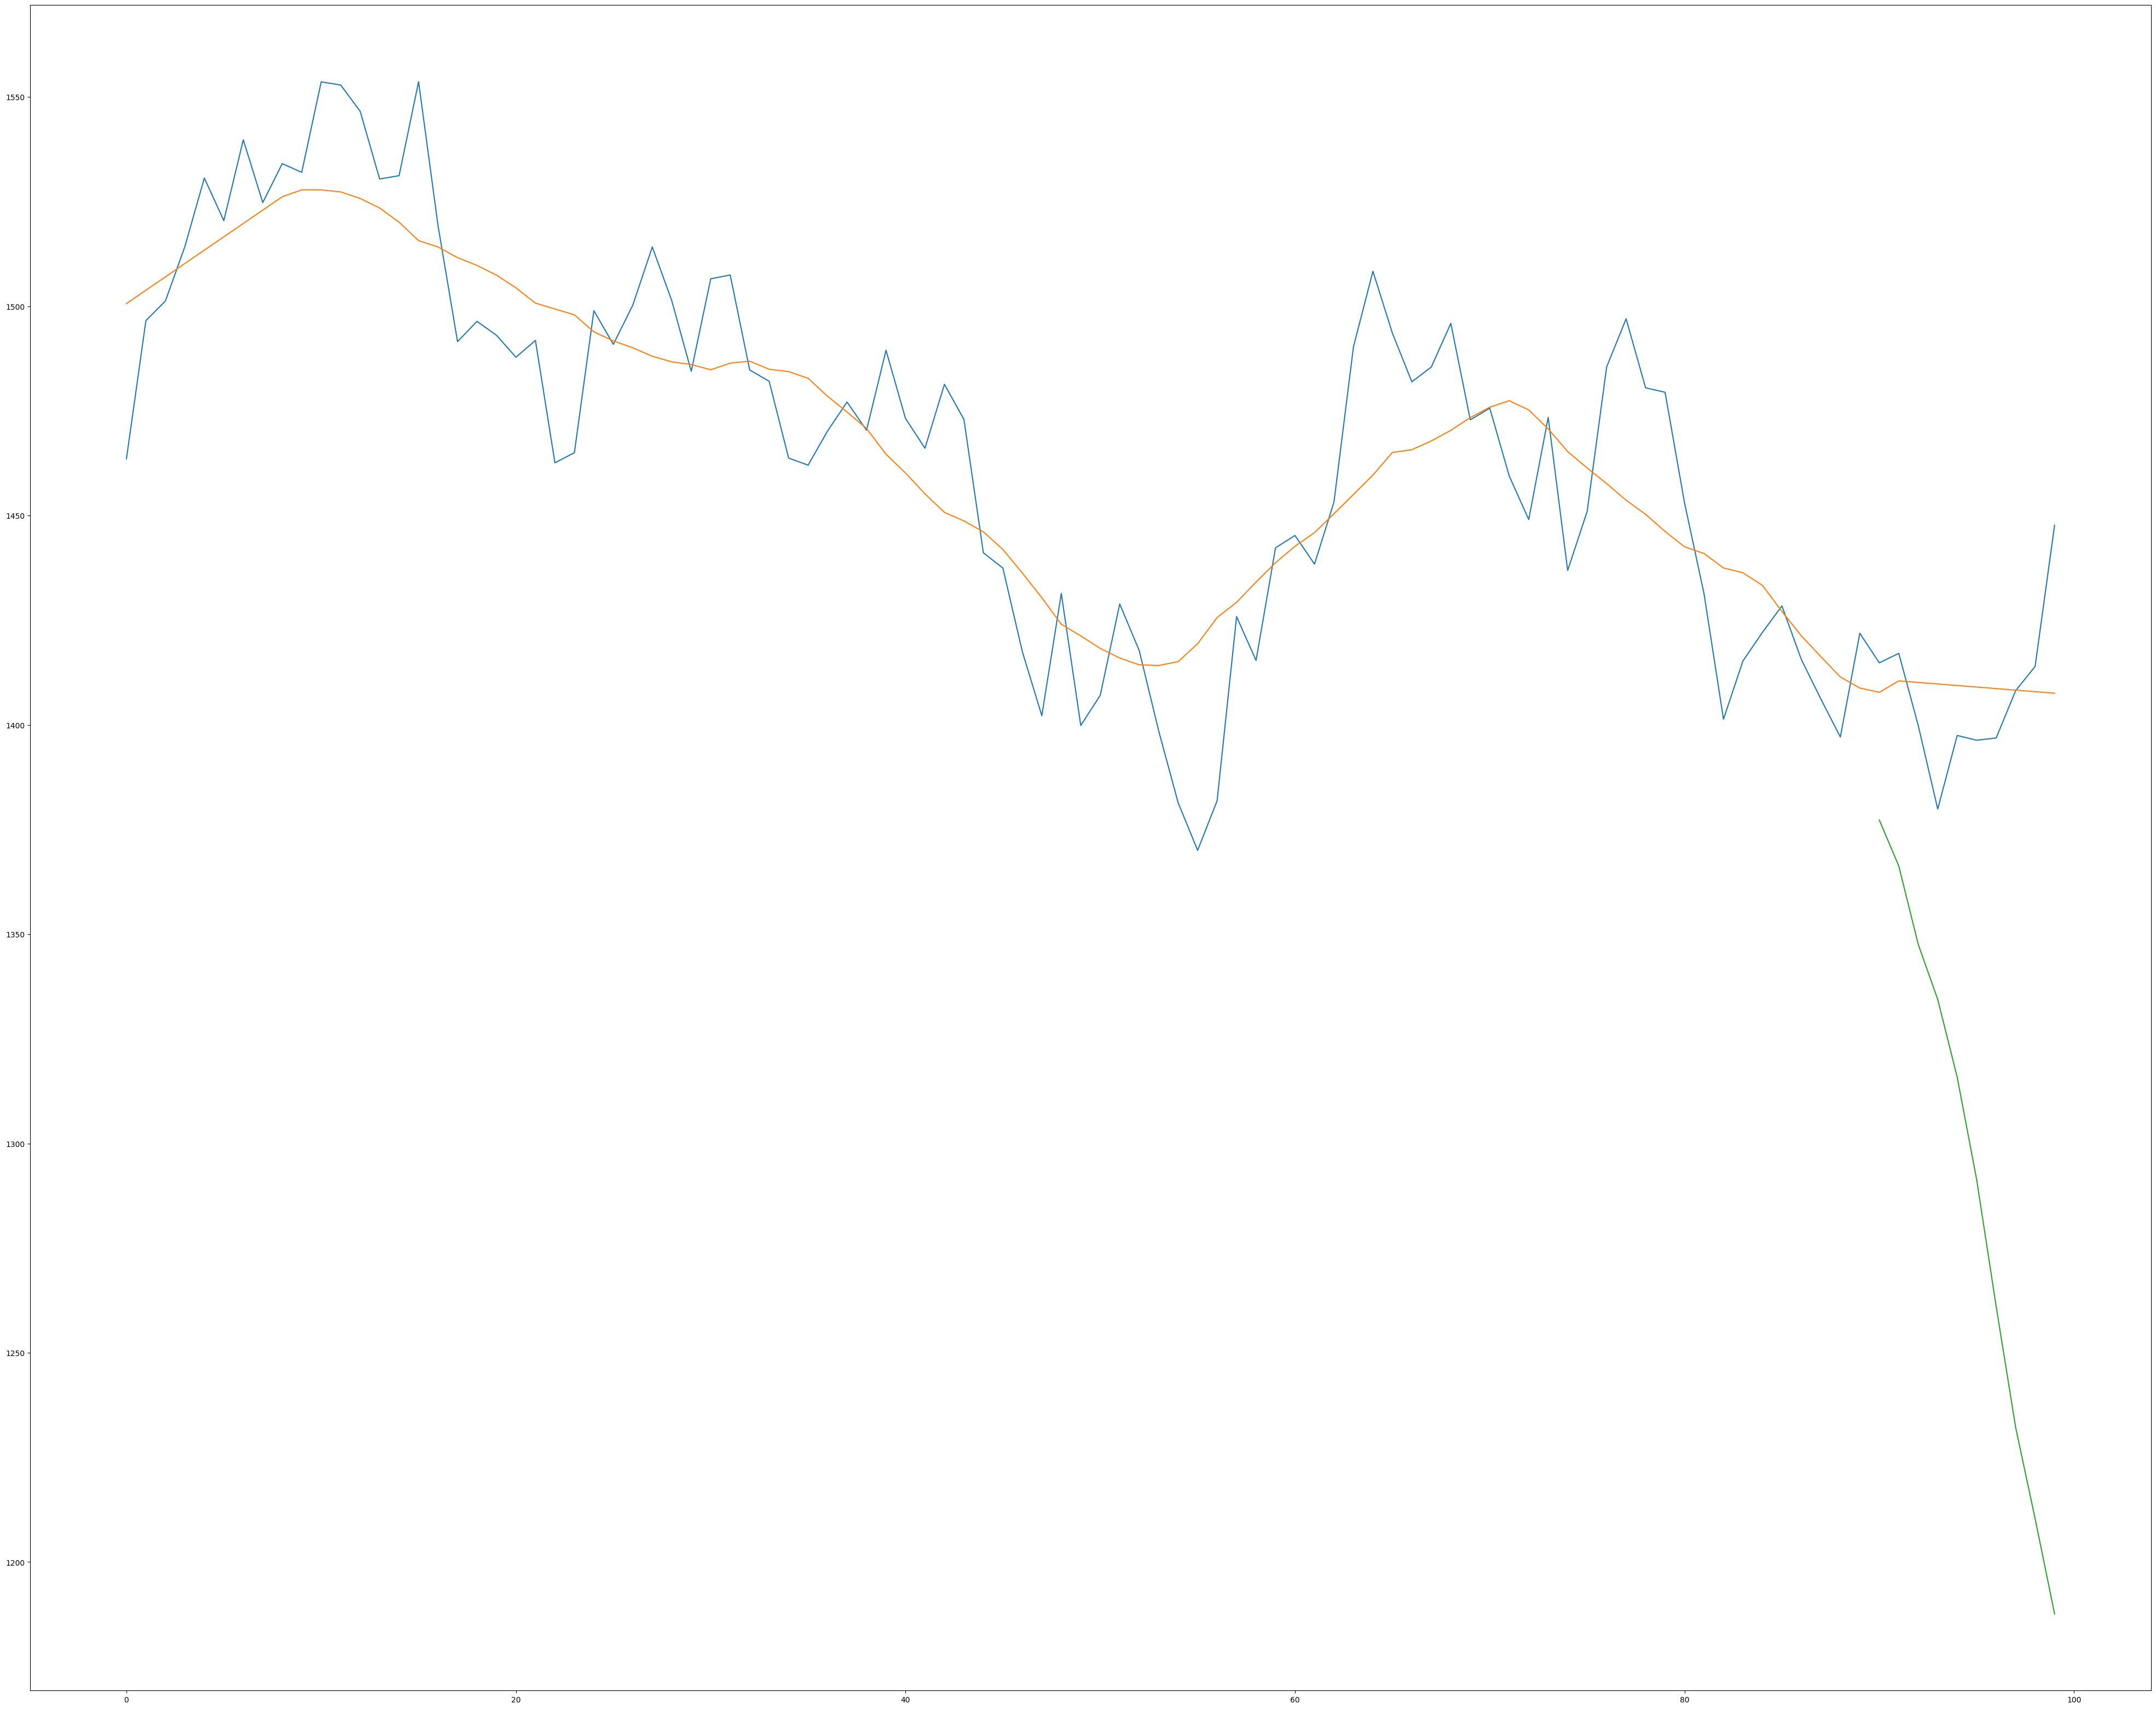

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))
plt.plot(data.index, data['close'], label='close')
plt.plot(data.index, test_savgol, label='close')
plt.plot(data.index[-10:], trend_forecast+season[-10:], label='s_close')

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Example time series data
#np.random.seed(0)
#time_series = np.sin(np.linspace(0, 4 * np.pi, 100)) + np.random.normal(0, 0.1, 100)

# Fit ARIMA model
model = ARIMA(test_savgol[:-20], order=(5, 1, 0))  # Adjust the order as needed
fit = model.fit()

# Generate forecasts
n_forecast = 20
forecast = fit.forecast(steps=n_forecast)


In [20]:
forecast.shape, season[-20:].shape

((20,), (20,))

In [21]:
forecast

array([1442.50155922, 1439.3410887 , 1436.37896326, 1433.86973699,
       1431.75038866, 1429.89269711, 1428.3332636 , 1427.01311789,
       1425.88121296, 1424.92881534, 1424.1215729 , 1423.43498262,
       1422.85560923, 1422.36450405, 1421.94804294, 1421.59598089,
       1421.29764651, 1421.04492381, 1420.83108136, 1420.64992762])

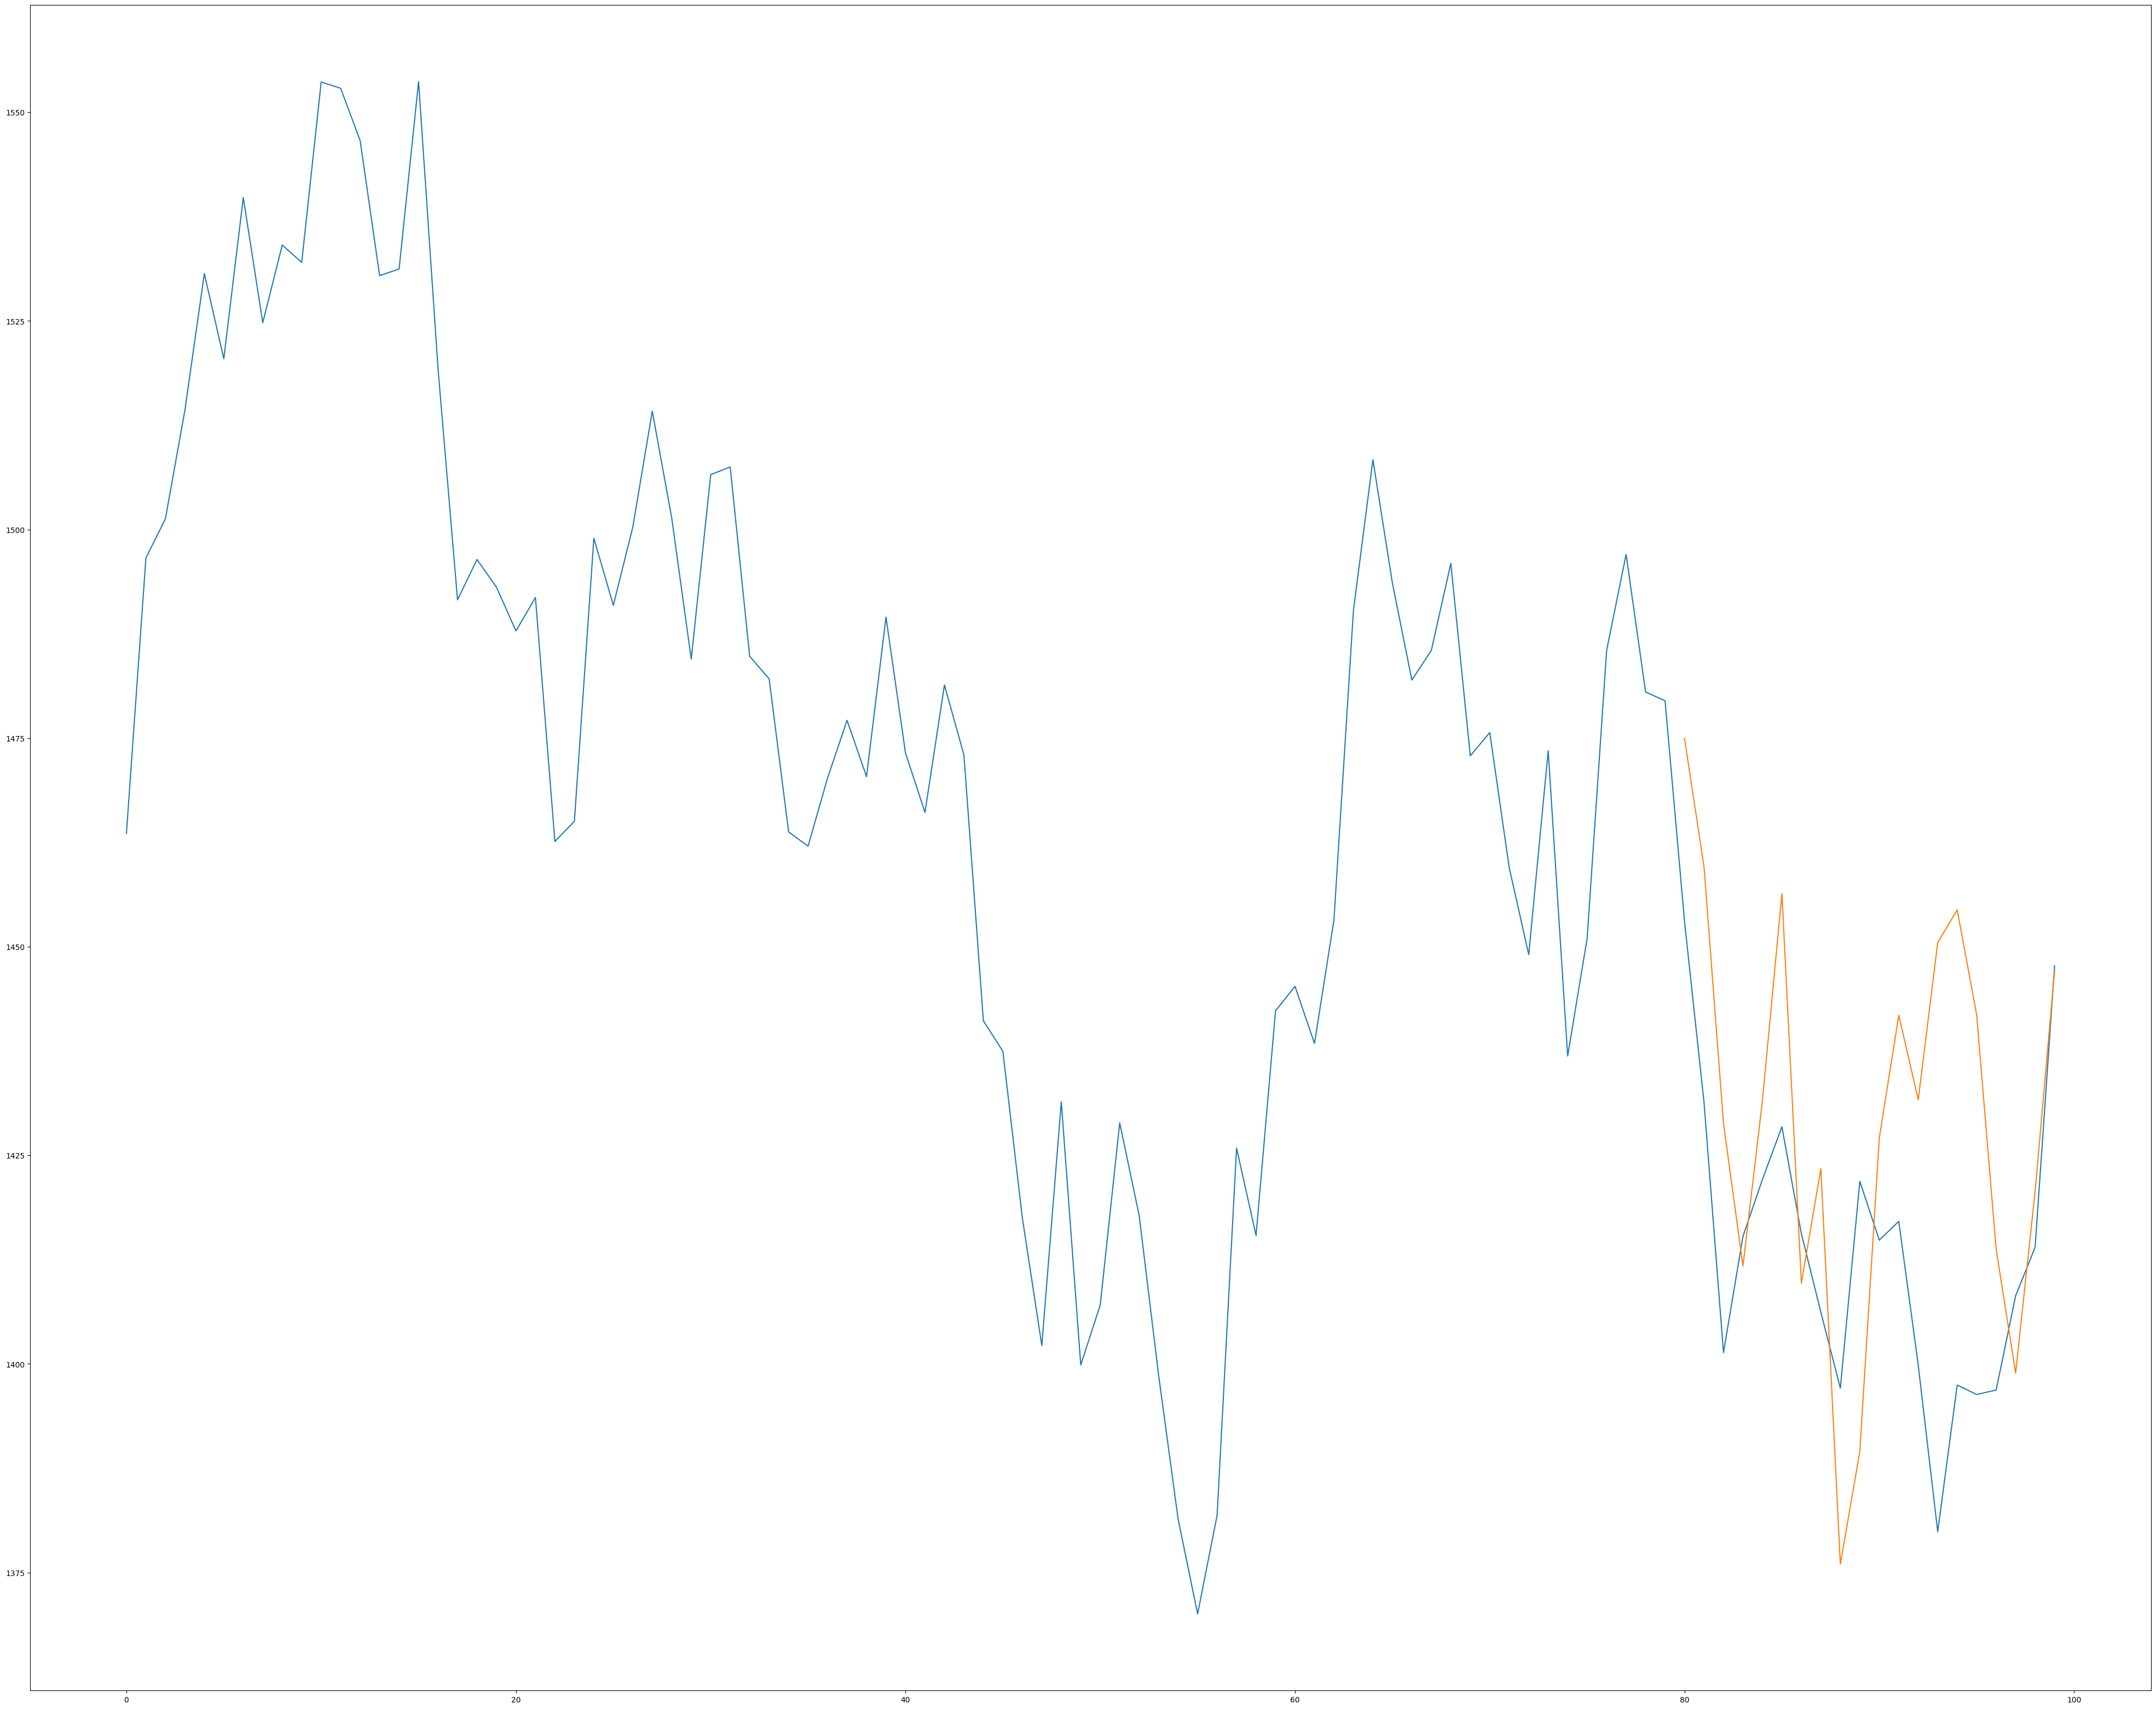

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))
plt.plot(data.index, data['close'], label='close')
plt.plot(data.index[-20:], forecast+season[-20:]*4, label='s_close')

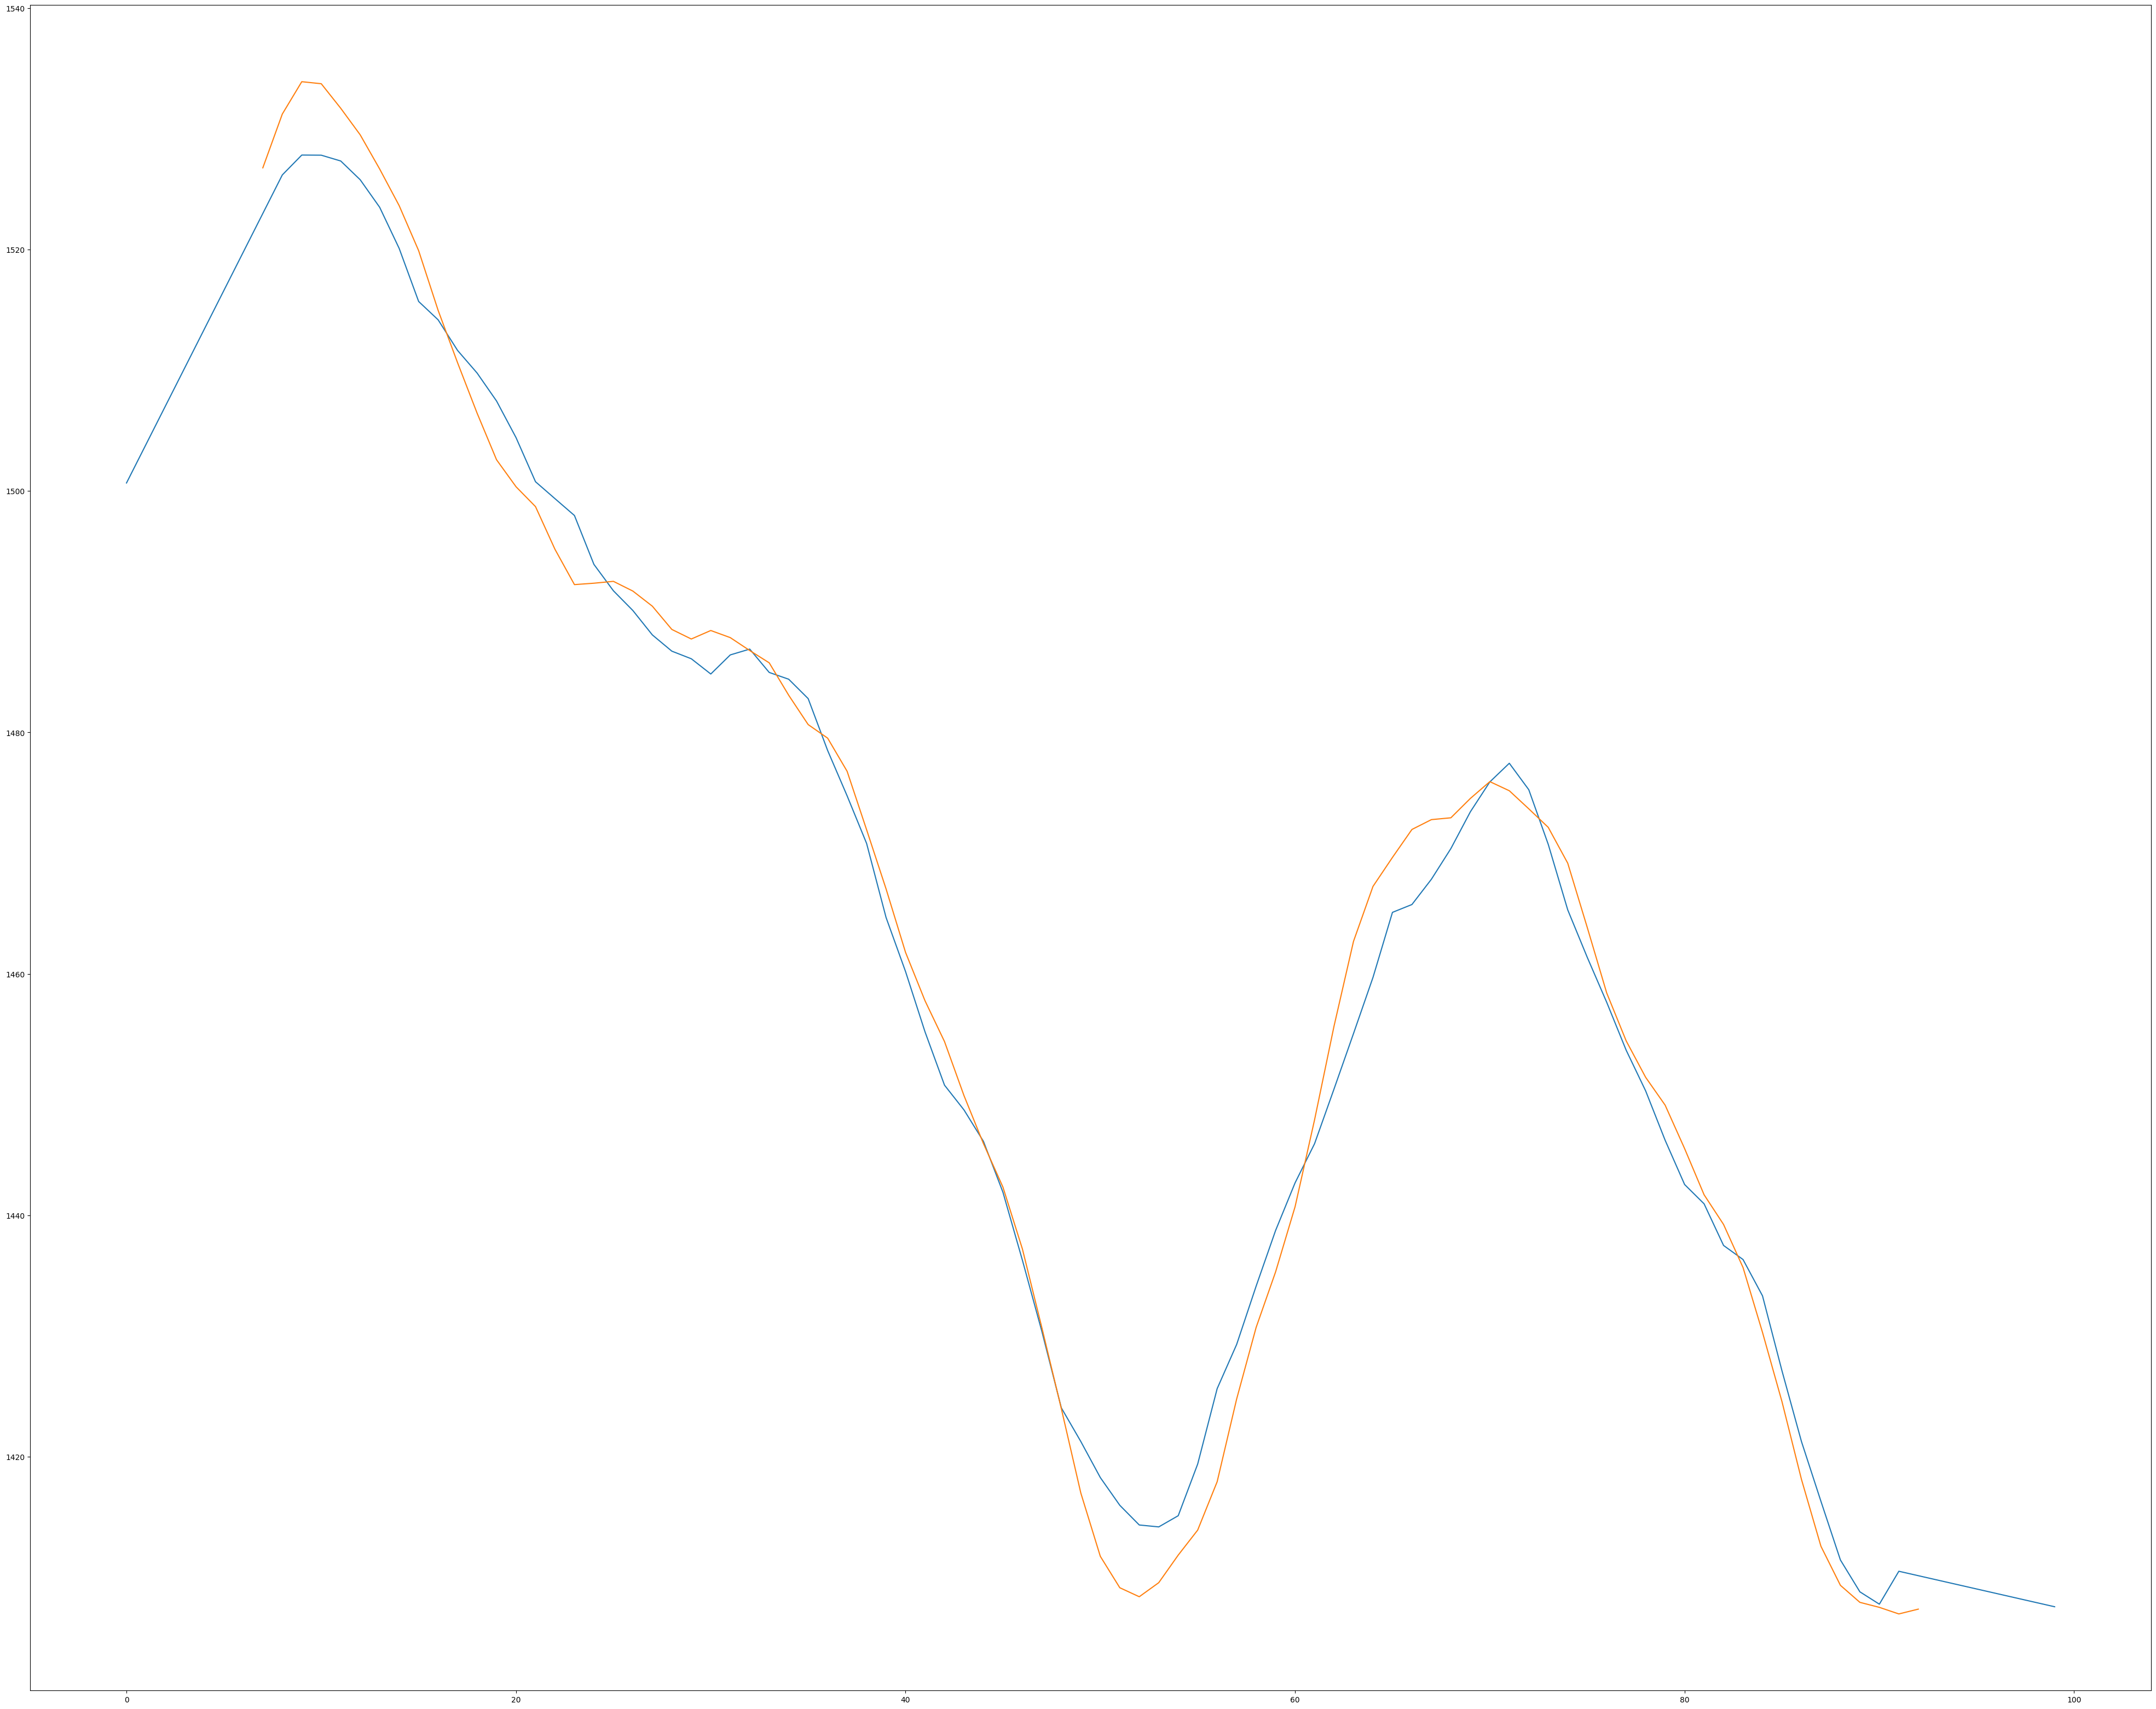

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))
plt.plot(data.index, test_savgol, label='close')
plt.plot(data.index, trend, label='s_close')

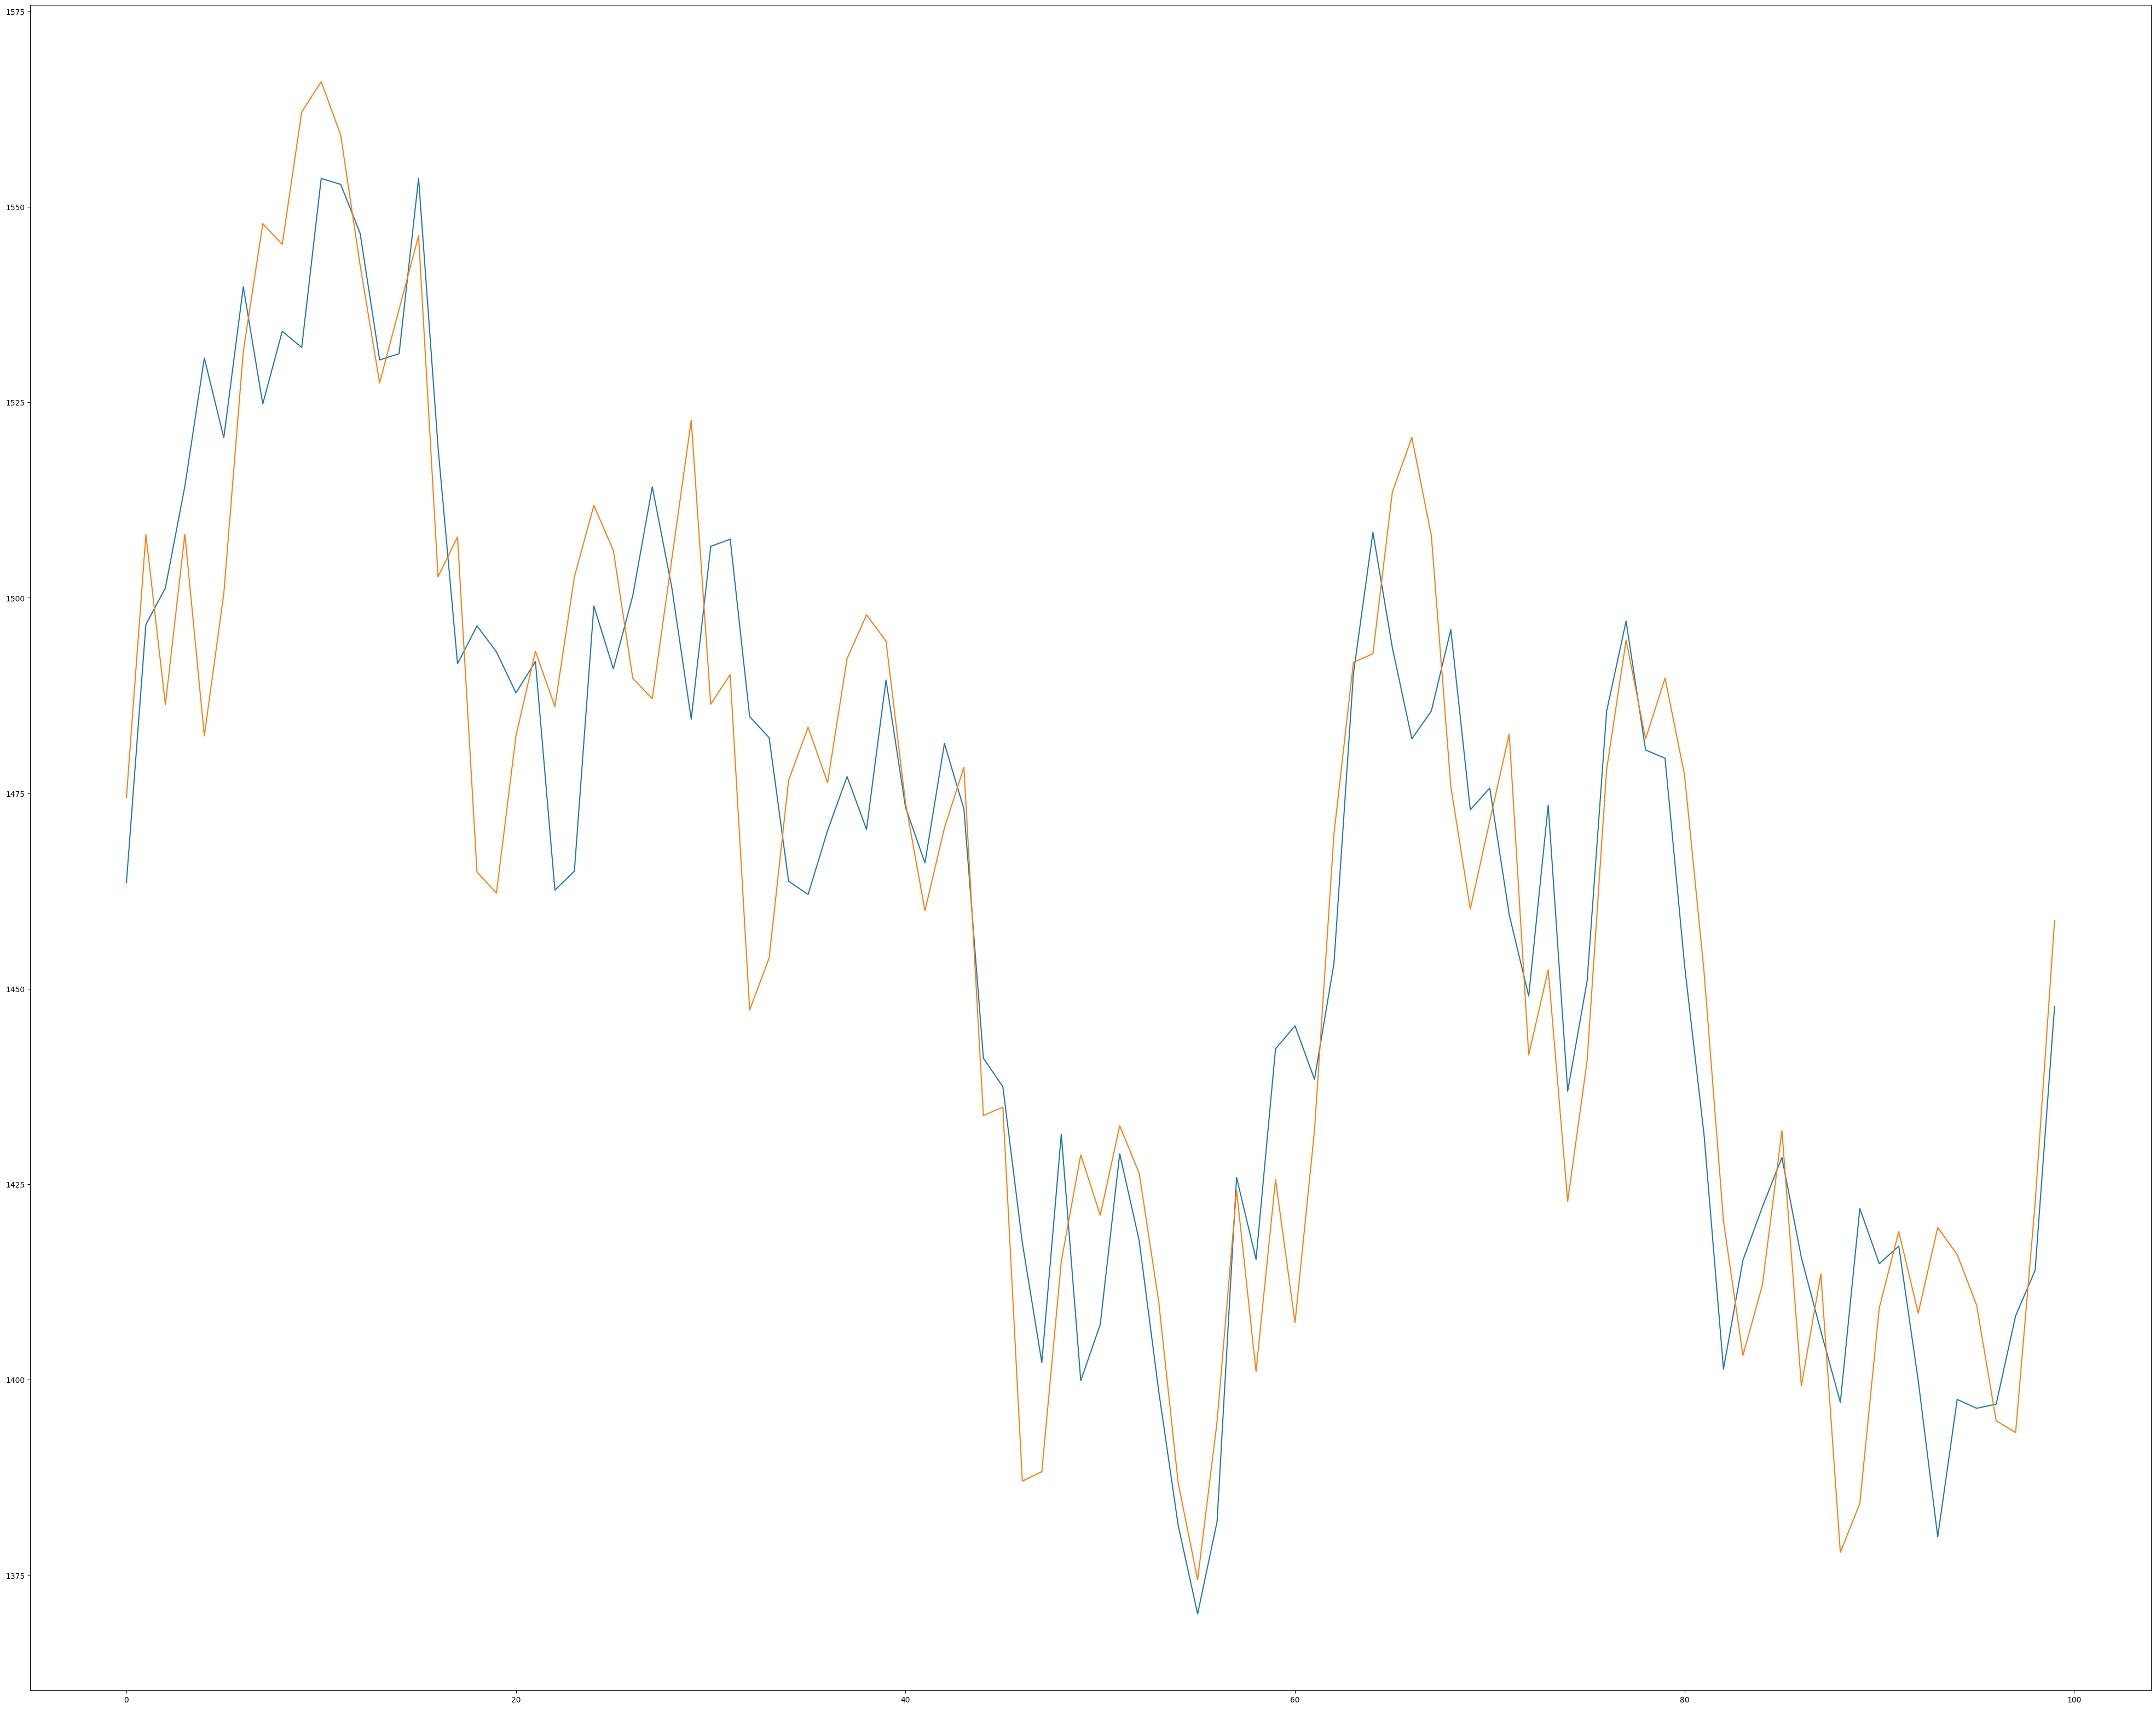

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))
plt.plot(data.index, data['close'], label='close')
plt.plot(data.index, data['s_close']+season*3, label='s_close')

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Define the slope and intercept
slope = 0.5  # Example slope
intercept = 0.4  # Example intercept

# Create a range of x-values
x_ref = np.linspace(1, 5, 10)  # Create 400 points between -10 and 10

# Calculate the corresponding y-values
y_ref = slope * x + intercept

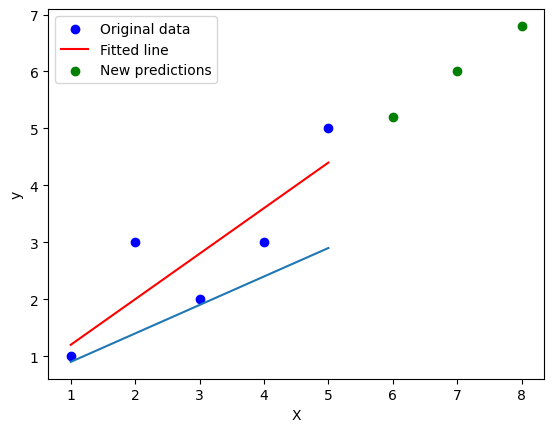

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Example dataset
X = np.array([1, 2, 3, 4, 5]).reshape(-1, 1)  # Features (independent variable)
y = np.array([1, 3, 2, 3, 5])  # Target (dependent variable)

# Create the linear regression model
model = LinearRegression()

# Fit the model to the data
model.fit(X, y)

# Predict values
y_pred = model.predict(X)

# Optionally, predict new values
X_new = np.array([6, 7, 8]).reshape(-1, 1)
y_new_pred = model.predict(X_new)

# Plotting the results
plt.scatter(X, y, color='blue', label='Original data')
plt.plot(X, y_pred, color='red', label='Fitted line')

# plot reference line
plt.plot(x_ref, y_ref)

# Optionally, plot new predictions
plt.scatter(X_new, y_new_pred, color='green', label='New predictions')

plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()


In [3]:
model.coef_

array([0.8])

In [4]:
model.intercept_

0.3999999999999999

In [4]:
data

date         open         high          low  \
0   2004-01-02 00:00:00-05:00  1474.160034  1479.589966  1458.510010   
1   2004-01-05 00:00:00-05:00  1474.550049  1496.579956  1474.189941   
2   2004-01-06 00:00:00-05:00  1492.410034  1504.469971  1486.589966   
3   2004-01-07 00:00:00-05:00  1498.380005  1514.449951  1491.199951   
4   2004-01-08 00:00:00-05:00  1524.060059  1530.650024  1513.339966   
..                        ...          ...          ...          ...   
95  2004-05-19 00:00:00-04:00  1414.380005  1427.510010  1396.339966   
96  2004-05-20 00:00:00-04:00  1400.369995  1408.199951  1390.410034   
97  2004-05-21 00:00:00-04:00  1409.609985  1414.109985  1397.699951   
98  2004-05-24 00:00:00-04:00  1418.770020  1425.489990  1408.439941   
99  2004-05-25 00:00:00-04:00  1412.589966  1450.060059  1406.199951   

          close      volume  
0   1463.569946  1666780000  
1   1496.579956  2362910000  
2   1501.260010  2273220000  
3   1514.260010  2294280000  
4   1530.650024  2683950000  
..          ...         ...  
95  1396.339966  1834960000  
96  1396.869995  1540900000  
97  1408.170044  1376620000  
98  1413.969971  1422080000  
99  1447.719971  1770600000  

[100 rows x 6 columns]

In [5]:
import numpy as np
from talib import RSI

rsi = np.array([ RSI(data['close'].iloc[i]) for i in range(data.shape[0]) ])

TypeError: Argument 'real' has incorrect type (expected numpy.ndarray, got numpy.float64)